# An Exploration of Bias Mitigation techniques using data generated by COMPAS 

## Imports

In [1]:
import sys
import math
import pickle
import json
import numpy as np
# !pip install scipy==1.6.0
# !pip install matplotlib==3.1.0
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display, Image
from tqdm import tqdm
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(1)

In [2]:
# AIF360
import aif360
from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
# fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric, DatasetMetric
from aif360.metrics.common_utils import compute_metrics
from aif360.metrics.utils import compute_num_instances
# data preprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
# explainers
from aif360.explainers import MetricTextExplainer
# bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover, GerryFairClassifier
from aif360.sklearn.inprocessing import AdversarialDebiasing as SKLearnAdversarialDebiasing
from aif360.algorithms.inprocessing.gerryfair.clean import array_to_tuple
from aif360.algorithms.inprocessing.gerryfair.auditor import Auditor
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification

from aif360.sklearn.utils import check_inputs, check_groups

In [3]:
# TensorFlow
import tensorflow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [57]:
import sklearn
# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree, linear_model
# metrics
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix
# kernels
from sklearn.kernel_ridge import KernelRidge

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.datasets import make_blobs
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance

## 1 Data

### Loading in the COMPAS dataset

**Loading in the data and defining attributes**

In [129]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
original_dataset = load_preproc_data_compas(['race'])

In [130]:
default_mappings = {'label_maps': [{1.0: 'Recid', 0.0: 'Non-Recid'}], 
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, 
    {1.0: 'White', 0.0: 'Non-White'}]}
metrics = ['Statistical parity difference', 'Average odds difference', 
    'Equal opportunity difference']

**Splitting data into training, testing and validation datasets**

In [132]:
original_train, original_val_test = original_dataset.split([0.7], shuffle = True)
original_val, original_test = original_val_test.split([0.5], shuffle = True)

**Calculating fairness metrics on the original COMPAS dataset**

In [133]:
def describe(train = None, val = None, test = None):
    if train is not None:
        display(Markdown('#### Training dataset shape'))
        print(train.features.shape)
    if val is not None:
        display(Markdown('#### Validation dataset shape'))
        print(val.features.shape)
    display(Markdown('#### Test dataset shape'))
    print(test.features.shape)
    display(Markdown('#### Favorable and unfavorable labels'))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown('#### Protected attribute names'))
    print(test.protected_attribute_names)
    display(Markdown('#### Privileged and unprivileged protected attribute values'))
    print(test.privileged_protected_attributes, test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(train.feature_names)

In [134]:
describe(original_train, original_val, original_test)

#### Training dataset shape

(3694, 10)


#### Validation dataset shape

(792, 10)


#### Test dataset shape

(792, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [135]:
original_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [136]:
original_explainer = MetricTextExplainer(original_metric)
display(Markdown('#### Original COMPAS training data'))

original_train_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Training data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_train_metric.mean_difference())

original_val_metric = BinaryLabelDatasetMetric(original_val, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Validation data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_val_metric.mean_difference())

original_test_metric = BinaryLabelDatasetMetric(original_test, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Testing data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_test_metric.mean_difference())

#### Original COMPAS training data

Training data: Difference in mean outcomes between unprivileged and privileged groups = -0.122235
Validation data: Difference in mean outcomes between unprivileged and privileged groups = -0.159928
Testing data: Difference in mean outcomes between unprivileged and privileged groups = -0.149911


### Initial data analysis

In [5]:
dataset = '/Users/megantennies/FYP/data/compas-scores-two-years.csv'
compas_data = pd.read_csv(dataset)
compas_data = compas_data[['sex', 'age_cat', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]
compas_data.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid
0,Male,Greater than 45,Other,0,F,0
1,Male,25 - 45,African-American,0,F,1
2,Male,Less than 25,African-American,4,F,1
3,Male,Less than 25,African-American,1,F,0
4,Male,25 - 45,Other,2,F,0


In [13]:
race_data = compas_data['race'].value_counts().rename_axis('race').reset_index(name = 'count')
age_data = compas_data['age_cat'].value_counts().rename_axis('age').reset_index(name = 'count')
sex_data = compas_data['sex'].value_counts().rename_axis('sex').reset_index(name = 'count')
charge_degree_data = compas_data['c_charge_degree'].value_counts().rename_axis('charge_degree').reset_index(name = 'count')
priors_data = compas_data['priors_count'].value_counts().rename_axis('priors').reset_index(name = 'count')

In [20]:
def plot_dist(attribute, data, x_label, rot, title, file_name):
    plt.figure(figsize = (10,7))
    ax = sns.barplot(x = attribute, y = 'count', data = data, palette = 'GnBu')
    for val in ax.patches:
        ax.annotate(format(val.get_height(), '.0f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
    sns.set_style('whitegrid')
    ax.set_xlabel(x_label)
    ax.set_ylabel('Number of individuals')
    if attribute == 'charge_degree':
        ax.set_xticklabels(['Felony', 'Misdemeanor'])
    plt.xticks(rotation = rot)
    plt.title(title)
    plt.savefig(file_name, bbox_inches = 'tight')

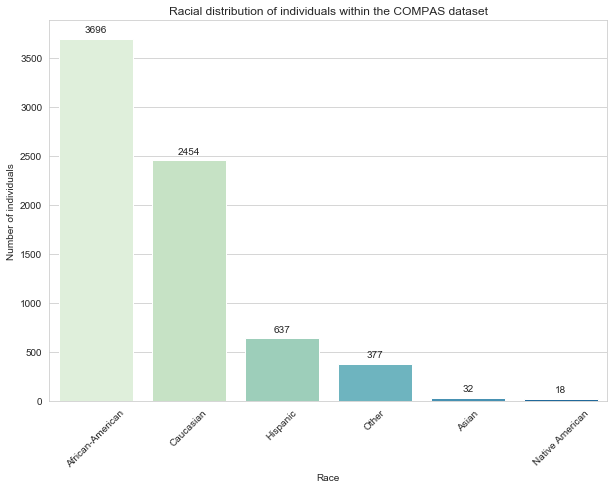

In [21]:
plot_dist(attribute = 'race', data = race_data, x_label = 'Race', rot = 45,
    title = 'Racial distribution of individuals within the COMPAS dataset', 
    file_name = 'racial_distribution.png')

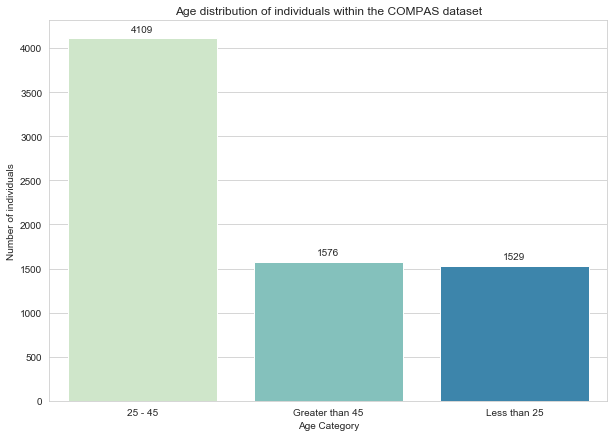

In [34]:
plot_dist(attribute = 'age', data = age_data, x_label = 'Age Category', 
    title = 'Age distribution of individuals within the COMPAS dataset', 
    file_name = 'age_distribution.png', rot = 0)

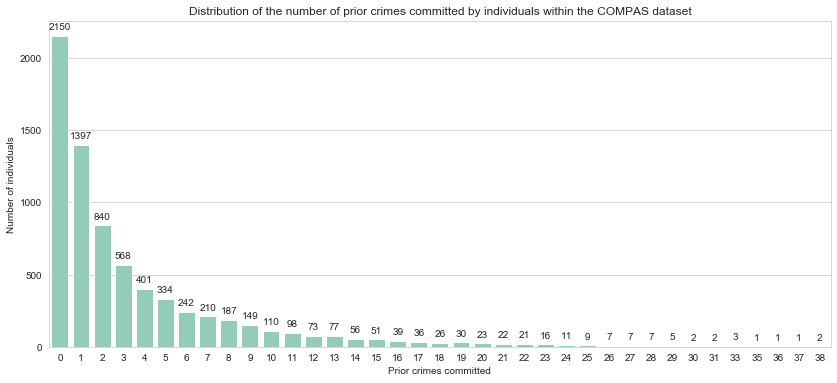

In [23]:
plt.figure(figsize = (14,6))
ax = sns.barplot(x = 'priors', y = 'count', data = priors_data, color = '#8cd4bc')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.0f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
ax.set_xlabel('Prior crimes committed')
ax.set_ylabel('Number of individuals')
plt.title('Distribution of the number of prior crimes committed by individuals within the COMPAS dataset')
plt.savefig('priors_distribution.png', bbox_inches = 'tight')

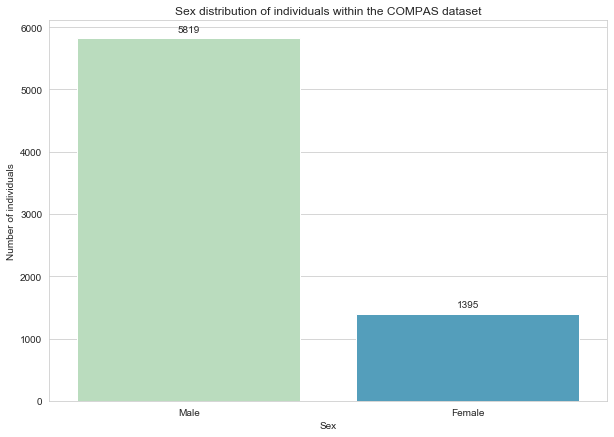

In [36]:
plot_dist(attribute = 'sex', data = sex_data, x_label = 'Sex', 
    title = 'Sex distribution of individuals within the COMPAS dataset', 
    file_name = 'sex_distribution.png', rot = 0)

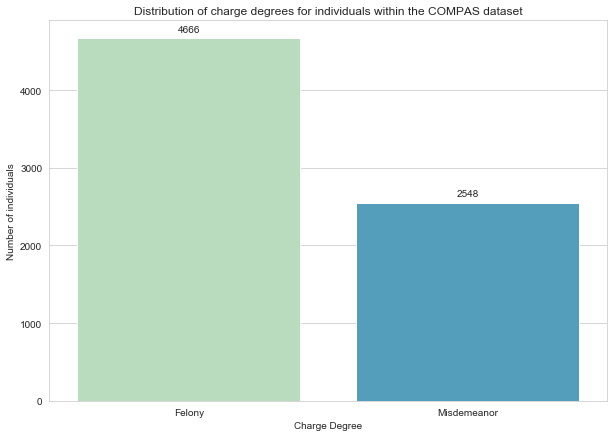

In [37]:
plot_dist(attribute = 'charge_degree', data = charge_degree_data, x_label = 'Charge Degree', 
    title = 'Distribution of charge degrees for individuals within the COMPAS dataset', 
    file_name = 'charge_distribution.png', rot = 0)

## 2 Feature Importance with a Forest of Trees

### Using specific (15) attributes

**Data generation**

In [6]:
compas_data = compas_data[['sex', 'age_cat', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]
compas_data.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid
0,Male,Greater than 45,Other,0,F,0
1,Male,25 - 45,African-American,0,F,1
2,Male,Less than 25,African-American,4,F,1
3,Male,Less than 25,African-American,1,F,0
4,Male,25 - 45,Other,2,F,0


In [7]:
object_data = compas_data[['age_cat', 'c_charge_degree', 'sex', 'race']]
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
categoricals = ['age_cat', 'c_charge_degree', 'sex', 'race']
encoded_data = pd.DataFrame(encoder.fit_transform(compas_data[categoricals]))
encoded_data.columns = encoder.get_feature_names_out(categoricals)
encoded_data.head()

,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
int_data = compas_data.select_dtypes(include = 'int64').copy()

In [9]:
concat_data = pd.concat([encoded_data, int_data], axis = 1)
concat_data.head()

,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,priors_count,two_year_recid
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,1
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0


**Fitting Random Forest Classifier**

In [28]:
data_array = concat_data.to_numpy()

In [29]:
seed = np.random.seed(1)

In [30]:
features = ['age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count']
X = data_array[:, 0:14]
y = data_array[:, 14]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [31]:
forest = RandomForestClassifier(random_state = 0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [32]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

**Feature importance based on MDI (Mean Decrease in Impurity)**

In [33]:
forest_importances_mdi = {'MDI_Feature': features, 'MDI_Importance': importances}
forest_importances_mdi = pd.DataFrame(data = forest_importances_mdi)

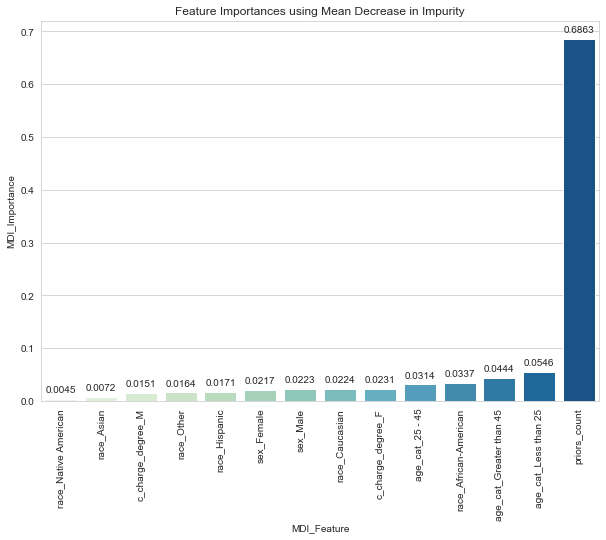

In [34]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'MDI_Feature', y = 'MDI_Importance', data = forest_importances_mdi, palette = 'GnBu', 
    order = forest_importances_mdi.sort_values('MDI_Importance').MDI_Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.title('Feature Importances using Mean Decrease in Impurity')
plt.xticks(rotation = 90)
plt.savefig('feat_import_MDI.png', bbox_inches = 'tight')

**Feature importance based on (FP) Feature Permutation**

In [35]:
feat_perm = permutation_importance(forest, X_test, y_test)

In [36]:
forest_importances_pi = {'FP_Feature': features, 'FP_Importance': feat_perm.importances_mean}
forest_importances_pi = pd.DataFrame(data = forest_importances_pi)

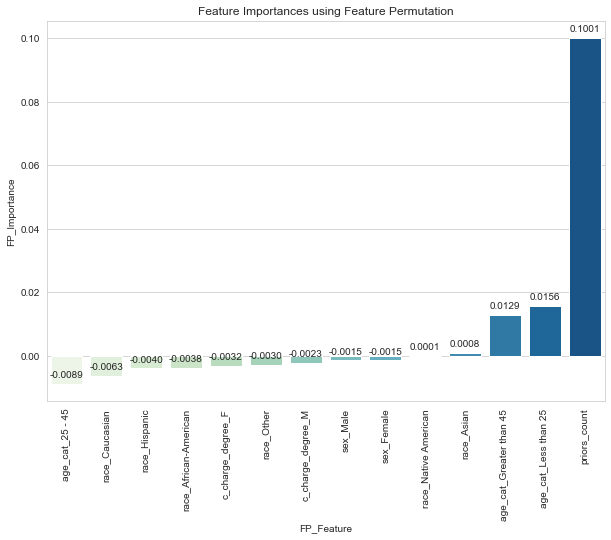

In [37]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'FP_Feature', y = 'FP_Importance', data = forest_importances_pi, palette = 'GnBu', 
    order = forest_importances_pi.sort_values('FP_Importance').FP_Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.title('Feature Importances using Feature Permutation')
plt.xticks(rotation = 90)
plt.savefig('feat_import_FP.png', bbox_inches = 'tight')

### Using grouped (5) attributes

In [38]:
forest_importances = pd.concat([forest_importances_mdi, forest_importances_pi], axis = 1)
forest_importances.drop(['FP_Feature'], axis = 1)

,MDI_Feature,MDI_Importance,FP_Importance
0,age_cat_25 - 45,0.031425,-0.008870
1,age_cat_Greater than 45,0.044375,0.012890
2,age_cat_Less than 25,0.054554,0.015593
3,c_charge_degree_F,0.023056,-0.003188
4,c_charge_degree_M,0.015126,-0.002287
5,sex_Female,0.021653,-0.001525
6,sex_Male,0.022305,-0.001525
7,race_African-American,0.033681,-0.003812
8,race_Asian,0.007168,0.000832
9,race_Caucasian,0.022390,-0.006306


In [39]:
age_cat_mdi = forest_importances.at[0, 'MDI_Importance'] + forest_importances.at[1, 'MDI_Importance'] \
    + forest_importances.at[2, 'MDI_Importance']
charge_degree_mdi = forest_importances.at[3, 'MDI_Importance'] + forest_importances.at[4, 'MDI_Importance']
sex_mdi = forest_importances.at[5, 'MDI_Importance'] + forest_importances.at[6, 'MDI_Importance']
race_mdi = forest_importances.at[7, 'MDI_Importance'] + forest_importances.at[8, 'MDI_Importance'] \
    + forest_importances.at[9, 'MDI_Importance'] + forest_importances.at[10, 'MDI_Importance'] \
    + forest_importances.at[11, 'MDI_Importance'] + forest_importances.at[12, 'MDI_Importance']
priors_mdi = forest_importances.at[13, 'MDI_Importance']

In [40]:
age_cat_fp = forest_importances.at[0, 'FP_Importance'] + forest_importances.at[1, 'FP_Importance'] \
    + forest_importances.at[2, 'FP_Importance']
charge_degree_fp = forest_importances.at[3, 'FP_Importance'] + forest_importances.at[4, 'FP_Importance']
sex_fp = forest_importances.at[5, 'FP_Importance'] + forest_importances.at[6, 'FP_Importance']
race_fp = forest_importances.at[7, 'FP_Importance'] + forest_importances.at[8, 'FP_Importance'] \
    + forest_importances.at[9, 'FP_Importance'] + forest_importances.at[10, 'FP_Importance'] \
    + forest_importances.at[11, 'FP_Importance'] + forest_importances.at[12, 'FP_Importance']
priors_fp = forest_importances.at[13, 'FP_Importance']

In [41]:
summative_importances = {'Feature': ['Age Category', 'Sex', 'Race', 'Charge Degree', 'Priors Count'],
    'Importance': [age_cat_mdi, sex_mdi, race_mdi, charge_degree_mdi, priors_mdi]}
summative_importances = pd.DataFrame(data = summative_importances)

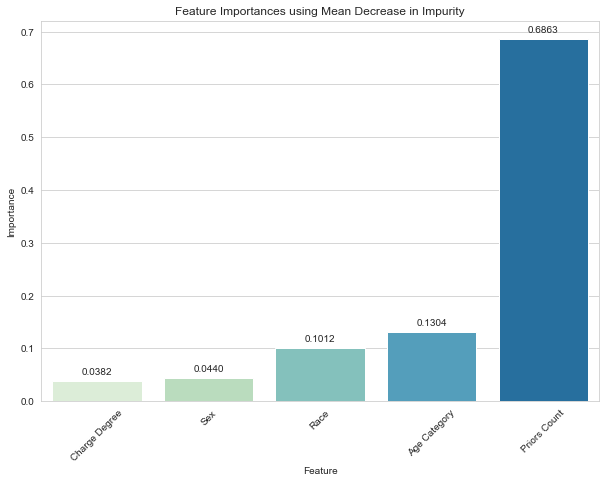

In [42]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Feature', y = 'Importance', data = summative_importances, palette = 'GnBu', 
    order = summative_importances.sort_values('Importance').Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.title('Feature Importances using Mean Decrease in Impurity')
plt.xticks(rotation = 45)
plt.savefig('feat_import_MDI_grouped.png', bbox_inches = 'tight')

In [43]:
summative_importances = {'Feature': ['Age Category', 'Sex', 'Race', 'Charge Degree', 'Priors Count'],
    'Importance': [age_cat_fp, sex_fp, race_fp, charge_degree_fp, priors_fp]}
summative_importances = pd.DataFrame(data = summative_importances)

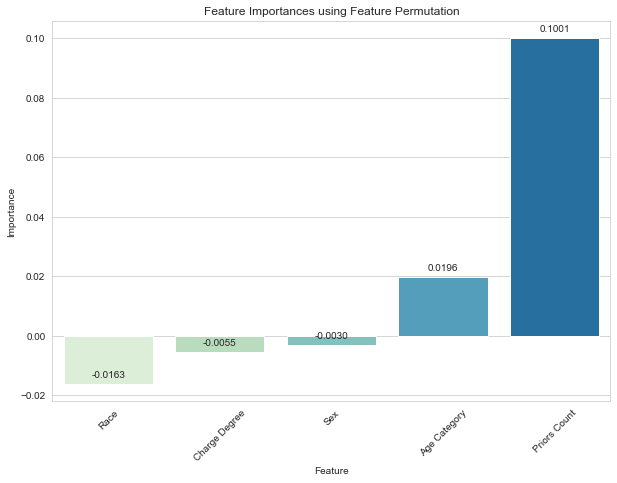

In [44]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Feature', y = 'Importance', data = summative_importances, palette = 'GnBu', 
    order = summative_importances.sort_values('Importance').Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.title('Feature Importances using Feature Permutation')
plt.xticks(rotation = 45)
plt.savefig('feat_import_FP_grouped.png', bbox_inches = 'tight')

### Comparision of MDI and FP Feature Importance

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


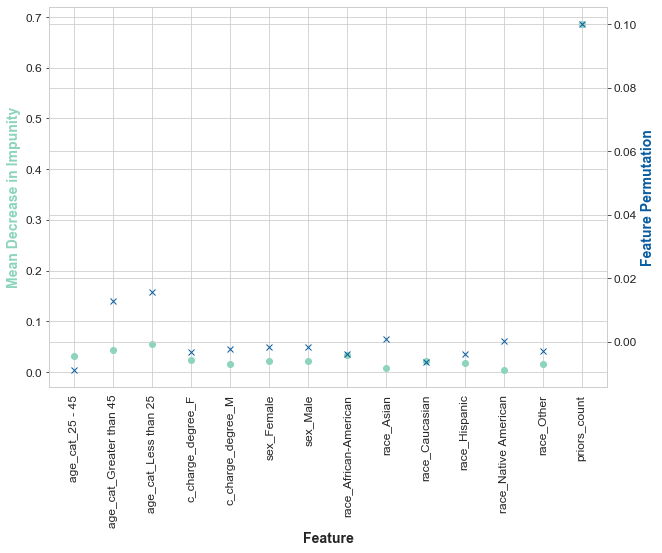

In [45]:
fig, ax1 = plt.subplots(figsize = (10, 7))
ax1.plot(forest_importances['MDI_Feature'], forest_importances['MDI_Importance'], color = '#8cd4bc', marker = 'o', linestyle = '')
ax1.set_xlabel('Feature', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Mean Decrease in Impunity', color = '#8cd4bc', fontsize = 14, fontweight = 'bold')
ax1.xaxis.set_tick_params(labelsize = 12)
ax1.yaxis.set_tick_params(labelsize = 12)
ax1.set_xticklabels(forest_importances['MDI_Feature'], rotation = 90)

ax2 = ax1.twinx()
ax2.plot(forest_importances['MDI_Feature'], forest_importances['FP_Importance'], color = '#085ca0', marker = 'x', linestyle = '')
ax2.set_ylabel('Feature Permutation', color = '#085ca0', fontsize = 14, fontweight = 'bold')
ax2.yaxis.set_tick_params(labelsize = 12)
ax2.grid(True)
plt.savefig('feat_import_comp.png', bbox_inches = 'tight')

### PCA

In [113]:
list(concat_data.columns)

['age_cat_25 - 45',
 'age_cat_Greater than 45',
 'age_cat_Less than 25',
 'c_charge_degree_F',
 'c_charge_degree_M',
 'sex_Female',
 'sex_Male',
 'race_African-American',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Native American',
 'race_Other',
 'priors_count',
 'two_year_recid']

In [114]:
concat_data['two_year_recid'].replace(0, 'No Recid', inplace = True)
concat_data['two_year_recid'].replace(1, 'Recid', inplace = True)
concat_data.head()

,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,priors_count,two_year_recid
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,No Recid
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,Recid
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,Recid
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,No Recid
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,No Recid


In [115]:
x = concat_data.loc[:, concat_data.columns != 'two_year_recid'].values
x = StandardScaler().fit_transform(x)

In [116]:
# checking to see that the normalised data has a mean of 0 and standard deviation of 1
np.mean(x), np.std(x)

(-1.2804346499696843e-17, 1.0)

In [117]:
y = concat_data.iloc[:, -1:]

In [118]:
pca = PCA().fit(x)

Text(0, 0.5, 'Cumulative Explained Variance')

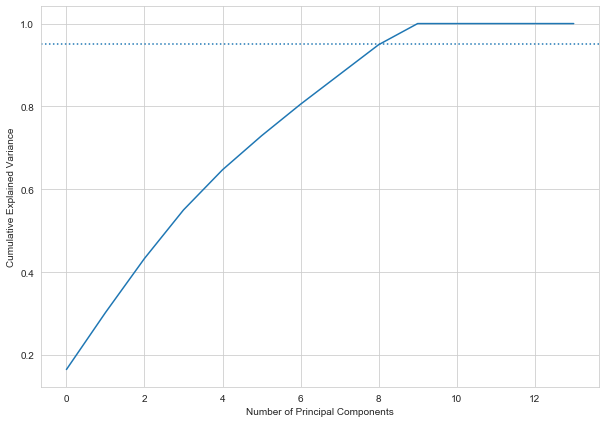

In [121]:
plt.figure(figsize = (10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.95, linestyle = ':')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
# this curve quantifies how much of the total, 14-dimensional variance is contained within the first N components

In [106]:
print('PCA Components: {}'.format(pca.components_))

PCA Components: [[-0.06600789  0.14294288 -0.06455232 -0.45853554  0.45853554  0.36570396
  -0.36570396 -0.34731887  0.0033278   0.31283203  0.06140315  0.00698206
   0.0332764  -0.24417837]
 [ 0.05951531 -0.15536248  0.08497501  0.33517274 -0.33517274  0.58835576
  -0.58835576  0.16489522 -0.03893153 -0.09654873 -0.09397317 -0.00471812
  -0.03233092 -0.01291803]]


In [122]:
pca = PCA(n_components = 2)
pca_comps = pca.fit_transform(x)
pca_data = pd.DataFrame(data = pca_comps, columns = ['principal_component_1', 'principal_component_2'])
pca_data['label'] = y
pca_data.head()

,principal_component_1,principal_component_2,label
0,-0.228954,-0.683274,No Recid
1,-1.552577,0.288087,Recid
2,-1.777270,0.365224,Recid
3,-1.627228,0.373161,No Recid
4,-0.808233,-0.192371,No Recid


In [123]:
print('Variation per principal component: {}'.format(pca.explained_variance_ratio_))
# principal component 1 holds 16.5% of the information, pc 2 holds 13.7% 
# ~70% of info was lost while projecting 14 dimensional data to 2 dimensional data

Variation per principal component: [0.16485817 0.13747641]


In [124]:
print('PCA Components: {}'.format(pca.components_))

PCA Components: [[-0.06600789  0.14294288 -0.06455232 -0.45853554  0.45853554  0.36570396
  -0.36570396 -0.34731887  0.0033278   0.31283203  0.06140315  0.00698206
   0.0332764  -0.24417837]
 [ 0.05951531 -0.15536248  0.08497501  0.33517274 -0.33517274  0.58835576
  -0.58835576  0.16489522 -0.03893153 -0.09654873 -0.09397317 -0.00471812
  -0.03233092 -0.01291803]]


In [125]:
def draw_vector(v0, v1, ax = None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle = '->', linewidth = 2, shrinkA = 0, shrinkB = 0)
    ax.annotate('', v1, v0, arrowprops = arrowprops)

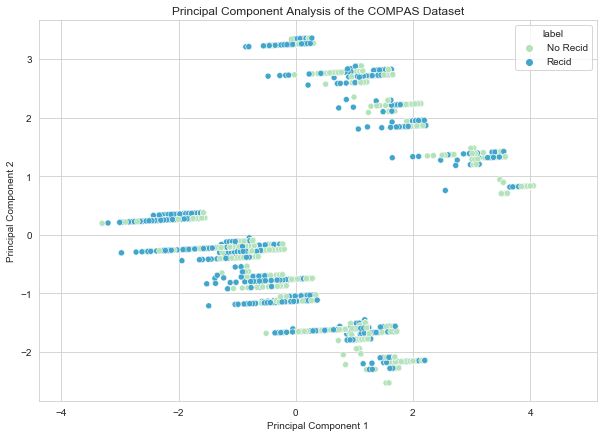

In [126]:
plt.figure(figsize = (10, 7))
ax = sns.scatterplot(x = 'principal_component_1', y = 'principal_component_2', hue = 'label',
    data = pca_data, legend = 'full', palette = sns.color_palette('GnBu', 2))
sns.set_style('whitegrid')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.title('Principal Component Analysis of the COMPAS Dataset')
plt.axis('equal')
plt.savefig('pca_2', bbox_inches = 'tight')

## 3 Logistic Regression model to predict Recidivism 

### Baseline Logistic Regression Model

**Training an LR model on the original dataset**

In [184]:
original_scaler = StandardScaler()
X_train = original_scaler.fit_transform(original_train.features)
y_train = original_train.labels.ravel()
w_train = original_train.instance_weights.ravel()

In [185]:
lr = LogisticRegression()
lr.fit(X_train, y_train, sample_weight = original_train.instance_weights)
y_train_preds = lr.predict(X_train)

**Defining the postive class index**

In [186]:
pos_ind = np.where(lr.classes_ == original_train.favorable_label)[0][0]

**Scoring original validation and testing sets**

In [187]:
original_train_preds = original_train.copy()
original_train_preds.labels = y_train_preds

In [188]:
original_val_preds = original_val.copy(deepcopy = True)
X_val = original_scaler.transform(original_val_preds.features)
y_val = original_val_preds.labels
original_val_preds.scores = lr.predict_proba(X_val)[:, pos_ind].reshape(-1, 1)

In [447]:
original_test_preds = original_test.copy(deepcopy = True)
X_test = original_scaler.transform(original_test_preds.features)
y_test = original_test_preds.labels
original_test_preds.scores = lr.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

**Finidng the optimal classification threshold from the validation set**

In [230]:
num_thresh = 100
bal_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

In [231]:
for idx, class_thresh in enumerate(class_thresh_arr):
    fav_inds = original_val_preds.scores > class_thresh
    original_val_preds.labels[fav_inds] = original_val_preds.favorable_label
    original_val_preds.labels[~fav_inds] = original_val_preds.unfavorable_label

    original_val_metric = ClassificationMetric(original_val, 
        original_val_preds, unprivileged_groups = unprivileged_groups, 
        privileged_groups = privileged_groups)

    bal_arr[idx] = 0.5 * (original_val_metric.true_positive_rate() 
        + original_val_metric.true_negative_rate())

In [232]:
best_ind = np.where(bal_arr == np.max(bal_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

In [250]:
display(Markdown('#### Original COMPAS data'))
print('Best balanced accuracy (no transforming): %.4f' % np.max(bal_arr))
print('Optimal classification threshold (no transforming): %.4f' % best_class_thresh)

#### Original COMPAS data

Best balanced accuracy (no transforming): 0.6859
Optimal classification threshold (no transforming): 0.4555


**Predictions for the original test set at the optimal classification threshold**

In [251]:
bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
eq_opp_diff_arr = []
theil_ind_arr = []
stat_par_diff_arr = []

In [252]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = original_test_preds.scores > thresh
    original_test_preds.labels[fav_inds] = original_test_preds.favorable_label
    original_test_preds.labels[~fav_inds] = original_test_preds.unfavorable_label
    
    metric_test = compute_metrics(original_test, original_test_preds, unprivileged_groups, privileged_groups, disp = disp)
    
    bal_acc_arr.append(metric_test['Balanced accuracy'])
    avg_odds_diff_arr.append(metric_test['Average odds difference'])
    disp_imp_arr.append(metric_test['Disparate impact'])
    stat_par_diff_arr.append(metric_test['Statistical parity difference'])
    eq_opp_diff_arr.append(metric_test['Equal opportunity difference'])
    theil_ind_arr.append(metric_test['Theil index'])

#### Predictions from the original testing data

100%|██████████| 100/100 [00:00<00:00, 611.81it/s]

Classification threshold used: 0.4555
Balanced accuracy = 0.6676
Statistical parity difference = -0.2186
Disparate impact = 0.7127
Average odds difference = -0.1772
Equal opportunity difference = -0.1055
Theil index = 0.1638


**Displaying results from the classification thresholds**

In [253]:
def plot_graphs(class_thresholds, best_threshold, balanced_acc, metric_to_plot, metric_name, line_col, title, file_name):
    fig, ax1 = plt.subplots(figsize = (10, 7))
    ax1.plot(class_thresholds, balanced_acc, color = '#aade86')
    ax1.set_xlabel('Classification Thresholds', fontsize = 14, fontweight = 'bold')
    ax1.set_ylabel('Balanced Accuracy', color = '#aade86', fontsize = 14, fontweight = 'bold')
    ax1.xaxis.set_tick_params(labelsize = 12)
    ax1.yaxis.set_tick_params(labelsize = 12)

    ax2 = ax1.twinx()
    ax2.plot(class_thresholds, metric_to_plot, color = line_col)
    ax2.set_ylabel(metric_name, color = line_col, fontsize = 14, fontweight = 'bold')
    ax2.axvline(best_threshold, color = 'k', linestyle = ':')
    ax2.yaxis.set_tick_params(labelsize = 12)
    ax2.grid(True)

    plt.title(title)
    plt.savefig(file_name, bbox_inches = 'tight')

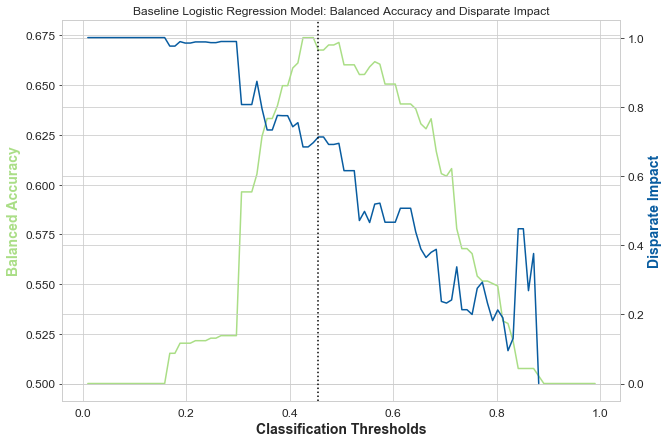

In [254]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr, metric_to_plot = disp_imp_arr, 
    metric_name = 'Disparate Impact', line_col = '#085ca0', 
    title = 'Baseline Logistic Regression Model: Balanced Accuracy and Disparate Impact', file_name = 'original_disp_imp')

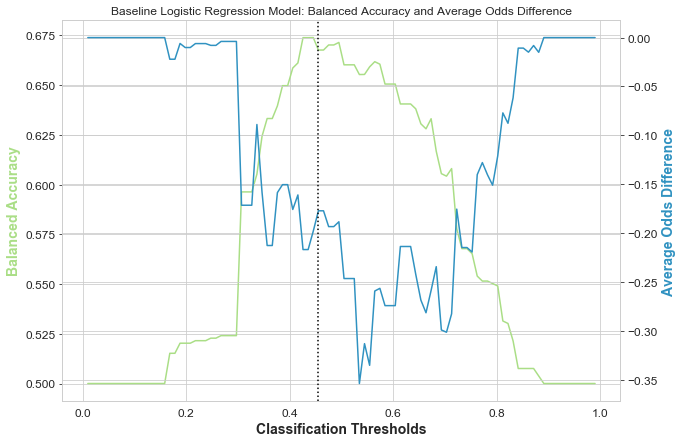

In [255]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr, metric_to_plot = avg_odds_diff_arr, 
    metric_name = 'Average Odds Difference', line_col = '#3092c1', 
    title = 'Baseline Logistic Regression Model: Balanced Accuracy and Average Odds Difference', file_name = 'original_avg_odds_diff')

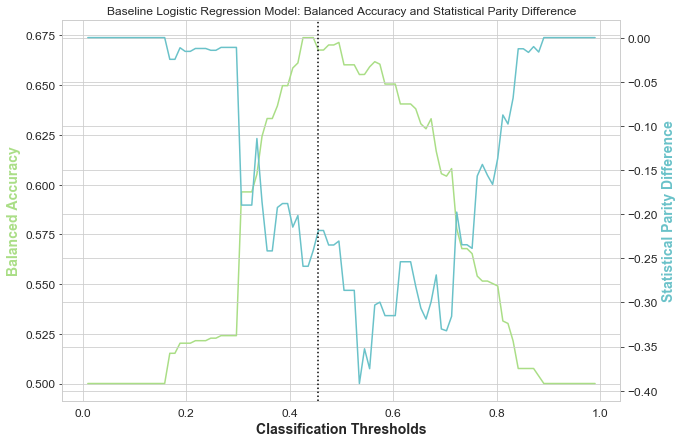

In [256]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr, metric_to_plot = stat_par_diff_arr, 
    metric_name = 'Statistical Parity Difference', line_col = '#6ac2c9', 
    title = 'Baseline Logistic Regression Model: Balanced Accuracy and Statistical Parity Difference', file_name = 'original_stat_par_diff')

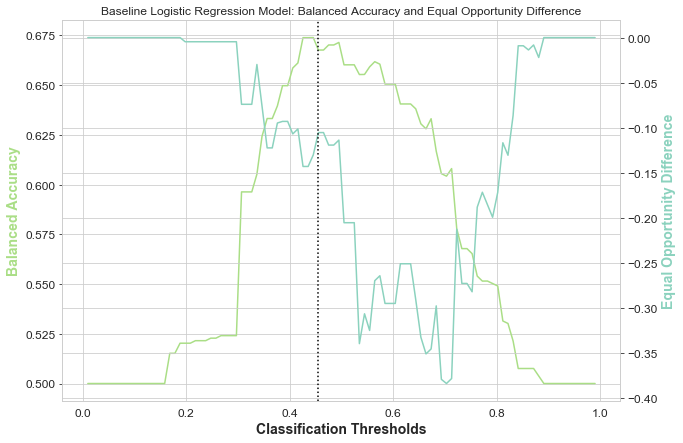

In [257]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr, metric_to_plot = eq_opp_diff_arr, 
    metric_name = 'Equal Opportunity Difference', line_col = '#8bd2be', 
    title = 'Baseline Logistic Regression Model: Balanced Accuracy and Equal Opportunity Difference', file_name = 'original_eq_opp_diff')

In [259]:
original_disp_imp = np.interp(best_class_thresh, class_thresh_arr, disp_imp_arr)
original_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr)
original_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr)
original_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr)
original_stat_par_diff = np.interp(best_class_thresh, class_thresh_arr, stat_par_diff_arr)
original_eq_opp_diff = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr)
original_theil_ind = np.interp(best_class_thresh, class_thresh_arr, theil_ind_arr)

### Comparing Predictive Accuracy for each group

In [448]:
original_data_metric = ClassificationMetric(original_test, original_test_preds, unprivileged_groups, privileged_groups)

**Calculating Generalised TP, FP, TN and FN Rates**

True Positive (TP) is the number of instances in the dataset where both the predicted and actual labels are 'favorable', 
$$ TP = \sum_{i=1}^n \mathbb{1}[y_i = \text{favorable}]\mathbb{1}[\hat{y}_i = \text{favorable}] $$

False Positive (FP) is the number of instances in the dataset where the predicted label is 'favorable', but the actual label was 'unfavorable'
$$ FP = \sum_{i=1}^n \mathbb{1}[y_i = \text{unfavorable}]\mathbb{1}[\hat{y}_i = \text{favorable}] $$

False Negative (FN) is the number of instances in the dataset where the predicted label is 'unfavorable', but the actual label was 'favorable'
$$ FN = \sum_{i=1}^n \mathbb{1}[y_i = \text{favorable}]\mathbb{1}[\hat{y}_i = \text{unfavorable}] $$

True Negative (TN) is the number of instances in the dataset where both the predicted and actual labels are 'unfavorable', 
$$ TN = \sum_{i=1}^n \mathbb{1}[y_i = \text{unfavorable}]\mathbb{1}[\hat{y}_i = \text{unfavorable}] $$

In [449]:
w, h = 2, 2
priv_matrix = [[0 for x in range(w)] for y in range(h)]
priv_matrix[0][0] = round(original_data_metric.num_generalized_true_positives(privileged = True))
priv_matrix[0][1] = round(original_data_metric.num_generalized_false_positives(privileged = True))
priv_matrix[1][0] = round(original_data_metric.num_generalized_false_negatives(privileged = True))
priv_matrix[1][1] = round(original_data_metric.num_generalized_true_negatives(privileged = True))
priv = pd.DataFrame(priv_matrix, index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])
print(priv)

          Positive  Negative
Positive       127        68
Negative        65        59


In [450]:
w, h = 2, 2
priv_matrix_g = [[0 for x in range(w)] for y in range(h)]
priv_matrix_g[0][0] = round(original_data_metric.generalized_true_positive_rate(privileged = True), 2)
priv_matrix_g[0][1] = round(original_data_metric.generalized_false_positive_rate(privileged = True), 2)
priv_matrix_g[1][0] = round(original_data_metric.generalized_false_negative_rate(privileged = True), 2)
priv_matrix_g[1][1] = round(original_data_metric.generalized_true_negative_rate(privileged = True), 2)
priv_g = pd.DataFrame(priv_matrix_g, index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])
print(priv_g)

          Positive  Negative
Positive      0.66      0.53
Negative      0.34      0.47


In [451]:
w, h = 2, 2
unpriv_matrix = [[0 for x in range(w)] for y in range(h)]
unpriv_matrix[0][0] = round(original_data_metric.num_generalized_true_positives(privileged = False))
unpriv_matrix[0][1] = round(original_data_metric.num_generalized_false_positives(privileged = False))
unpriv_matrix[1][0] = round(original_data_metric.num_generalized_false_negatives(privileged = False))
unpriv_matrix[1][1] = round(original_data_metric.num_generalized_true_negatives(privileged = False))
unpriv = pd.DataFrame(unpriv_matrix, index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])
print(unpriv)

          Positive  Negative
Positive       116       124
Negative        85       148


In [452]:
w, h = 2, 2
unpriv_matrix_g = [[0 for x in range(w)] for y in range(h)]
unpriv_matrix_g[0][0] = round(original_data_metric.generalized_true_positive_rate(privileged = False), 2)
unpriv_matrix_g[0][1] = round(original_data_metric.generalized_false_positive_rate(privileged = False), 2)
unpriv_matrix_g[1][0] = round(original_data_metric.generalized_false_negative_rate(privileged = False), 2)
unpriv_matrix_g[1][1] = round(original_data_metric.generalized_true_negative_rate(privileged = False), 2)
unpriv_g = pd.DataFrame(unpriv_matrix_g, index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])
print(unpriv_g)

          Positive  Negative
Positive      0.58      0.46
Negative      0.42      0.54


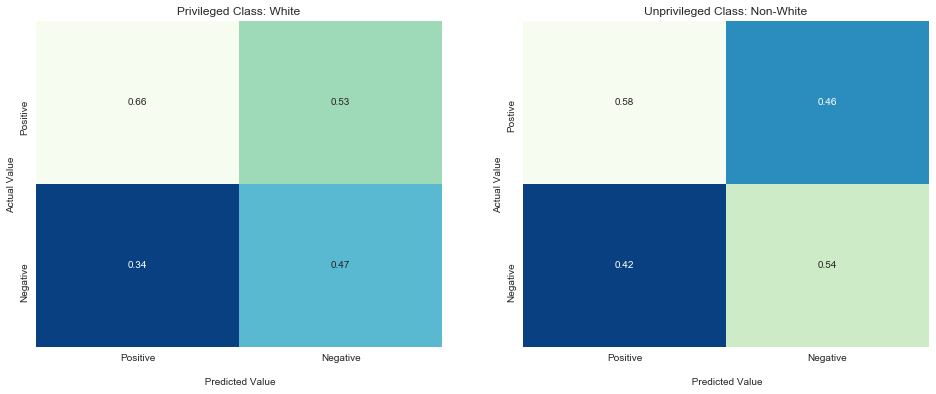

<Figure size 432x288 with 0 Axes>

In [453]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (16, 6))

sns.heatmap(priv_g, annot = True, cmap = 'GnBu_r', ax = ax1, cbar = False)
ax1.set_title('Privileged Class: White')
ax1.set_xlabel('\n Predicted Value')
ax1.set_ylabel('Actual Value')
ax1.xaxis.set_ticklabels(['Positive', 'Negative'])
ax1.yaxis.set_ticklabels(['Positive', 'Negative'])

sns.heatmap(unpriv_g, annot = True, cmap = 'GnBu_r', ax = ax2, cbar = False)
ax2.set_title('Unprivileged Class: Non-White')
ax2.set_xlabel('\n Predicted Value')
ax2.set_ylabel('Actual Value')
ax2.xaxis.set_ticklabels(['Positive', 'Negative'])
ax2.yaxis.set_ticklabels(['Postive', 'Negative'])

plt.show()
plt.savefig('conf_matrices.png', bbox_inches = 'tight')

## 4 Applying pre-processing techniques

### Reweighing

**Transforming original data using Reweighing**

In [260]:
rw = Reweighing(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
rw.fit(original_train)
reweighed_train = rw.transform(original_train)

In [261]:
assert np.abs(reweighed_train.instance_weights.sum() 
    - original_train.instance_weights.sum()) < 1e-6

**Calculating fairness metrics on the reweighed dataset**

In [262]:
reweighed_metric = BinaryLabelDatasetMetric(reweighed_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

In [263]:
reweighed_explainer = MetricTextExplainer(reweighed_metric)
display(Markdown('#### Reweighed COMPAS training data'))
print(reweighed_explainer.disparate_impact())

reweighed_train_metric = BinaryLabelDatasetMetric(reweighed_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % original_train_metric.mean_difference())

#### Reweighed COMPAS training data

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.122235


In [264]:
assert np.abs(reweighed_metric.mean_difference()) < 1e-6

**Training LR model on transformed data**

In [265]:
reweighed_scaler = StandardScaler()
X_train_rw = reweighed_scaler.fit_transform(reweighed_train.features)
y_train_rw = reweighed_train.labels.ravel()

In [266]:
lr = LogisticRegression()
lr.fit(X_train_rw, y_train_rw, sample_weight = reweighed_train.instance_weights)
y_train_preds_rw = lr.predict(X_train_rw)

**Scoring reweighed testing set**

In [267]:
reweighed_test_preds = original_test.copy(deepcopy = True)
X_test_rw = reweighed_scaler.fit_transform(reweighed_test_preds.features)
y_test_rw = reweighed_test_preds.labels
reweighed_test_preds.scores = lr.predict_proba(X_test_rw)[:, pos_ind].reshape(-1, 1)

**Predictions for the reweighed test set at the optimal classification threshold**

In [268]:
bal_acc_arr_rw = []
disp_imp_arr_rw = []
avg_odds_diff_arr_rw = []
stat_par_diff_arr_rw = []
eq_opp_diff_arr_rw = []
theil_ind_arr_rw = []

In [269]:
display(Markdown('#### Predictions from the transformed testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = reweighed_test_preds.scores > thresh
    reweighed_test_preds.labels[fav_inds] = reweighed_test_preds.favorable_label
    reweighed_test_preds.labels[~fav_inds] = reweighed_test_preds.unfavorable_label
    
    rw_metric_test = compute_metrics(original_test, reweighed_test_preds, 
        unprivileged_groups, privileged_groups, disp = disp)
    
    bal_acc_arr_rw.append(rw_metric_test['Balanced accuracy'])
    avg_odds_diff_arr_rw.append(rw_metric_test['Average odds difference'])
    disp_imp_arr_rw.append(rw_metric_test['Disparate impact'])
    stat_par_diff_arr_rw.append(rw_metric_test['Statistical parity difference'])
    eq_opp_diff_arr_rw.append(rw_metric_test['Equal opportunity difference'])
    theil_ind_arr_rw.append(rw_metric_test['Theil index'])

#### Predictions from the transformed testing data

 55%|█████▌    | 55/100 [00:00<00:00, 538.40it/s]divide by zero encountered in double_scalars
invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 527.32it/s]

Classification threshold used: 0.4555
Balanced accuracy = 0.6587
Statistical parity difference = -0.0836
Disparate impact = 0.8809
Average odds difference = -0.0399
Equal opportunity difference = 0.0036
Theil index = 0.1567


**Displaying results from the classification threshold**

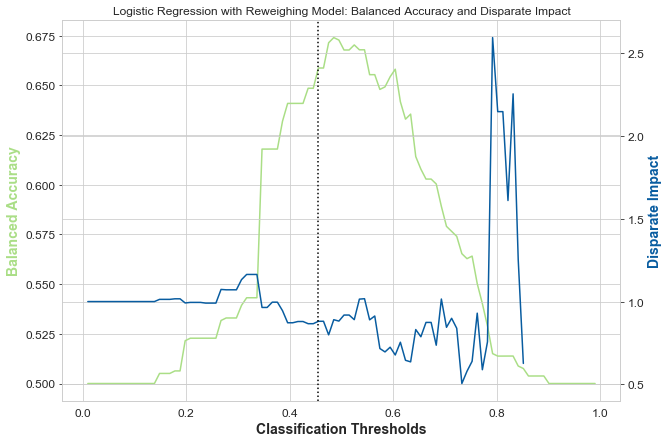

In [270]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_rw, metric_to_plot = disp_imp_arr_rw, 
    metric_name = 'Disparate Impact', line_col = '#085ca0', 
    title = 'Logistic Regression with Reweighing Model: Balanced Accuracy and Disparate Impact', 
    file_name = 'reweighed_disp_imp')

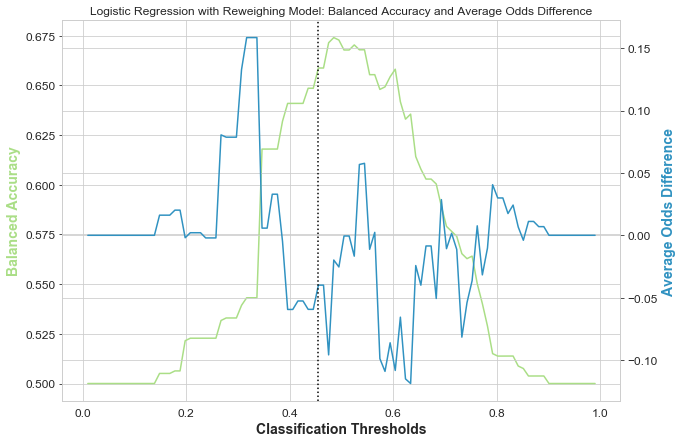

In [271]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_rw, metric_to_plot = avg_odds_diff_arr_rw, 
    metric_name = 'Average Odds Difference', line_col = '#3092c1', 
    title = 'Logistic Regression with Reweighing Model: Balanced Accuracy and Average Odds Difference',
    file_name = 'reweighed_avg_odds_diff')

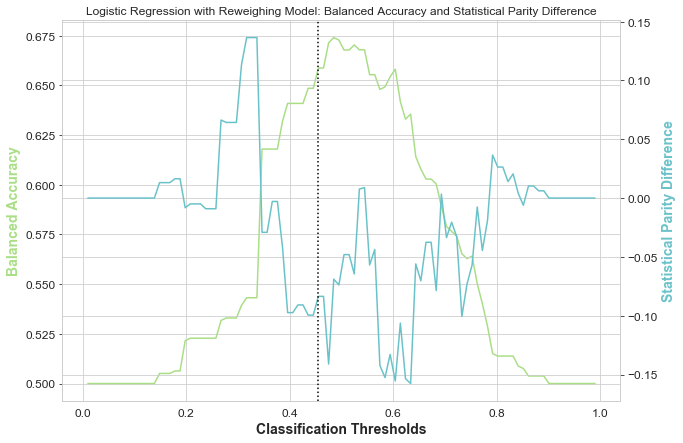

In [272]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_rw, metric_to_plot = stat_par_diff_arr_rw, 
    metric_name = 'Statistical Parity Difference', line_col = '#6ac2c9', 
    title = 'Logistic Regression with Reweighing Model: Balanced Accuracy and Statistical Parity Difference', 
    file_name = 'reweighed_stat_par_diff')

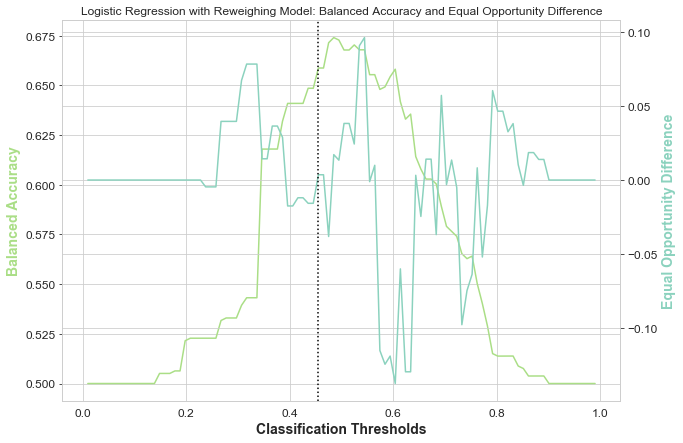

In [273]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_rw, metric_to_plot = eq_opp_diff_arr_rw, 
    metric_name = 'Equal Opportunity Difference', line_col = '#8bd2be', 
    title = 'Logistic Regression with Reweighing Model: Balanced Accuracy and Equal Opportunity Difference', 
    file_name = 'reweighed_eq_opp_diff')

In [275]:
reweighed_disp_imp = np.interp(best_class_thresh, class_thresh_arr, np.abs(1.0 - np.array(disp_imp_arr_rw)))
reweighed_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_rw)
reweighed_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr_rw)
reweighed_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_rw)
reweighed_stat_par_diff = np.interp(best_class_thresh, class_thresh_arr, stat_par_diff_arr_rw)
reweighed_eq_opp_diff = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr_rw)
reweighed_theil_ind = np.interp(best_class_thresh, class_thresh_arr, theil_ind_arr_rw)

## 5 Applying in-processing techniques

### Adversarial Debiasing Algorithm

**Splitting COMPAS data**

In [276]:
# session.close()
# tf.reset_default_graph()
session = tf.Session()

In [277]:
X, y = fetch_compas(binary_race = True)
X.index = pd.MultiIndex.from_arrays(X.index.codes, names = X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names = y.index.names)
y = 1 - pd.Series(y.factorize(sort = True)[0], index = y.index)

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234567)
data_preproc = make_column_transformer((OneHotEncoder(sparse = False, handle_unknown = 'ignore'), 
        X_train.dtypes == 'category'), remainder = StandardScaler())
X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index = X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index = X_test.index)

**Hyperparameter selection: Adversarial loss weight**

In [9]:
def find_loss_weights(loss_weights):
    weights = {'Adversarial Loss Weight': [], 'Mean Accuracy': []}
    for weight in loss_weights:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', adversary_loss_weight = weight)
        ad = ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        weights['Adversarial Loss Weight'].append(weight)
        weights['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(weights)

In [16]:
loss_weights = [i for i in np.linspace(0.01, 1.0, 20)]
weights = find_loss_weights(loss_weights = loss_weights)

In [108]:
def plot_params(param, metric, param_data, best_x, best_y, title, file_name):
    plt.figure(figsize = (10, 7))
    ax = sns.lineplot(x = param, y = metric, data = param_data, color = '#6ac2c9')
    if param == 'Adversarial Loss Weight':
        ax.annotate(s = ' x = {:.2f}, y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    elif param == 'Number of Hidden Units':
        ax.annotate(s = ' x = {:}, \n y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    sns.set_style('whitegrid')
    plt.title(title)
    plt.savefig(file_name, bbox_inches = 'tight')

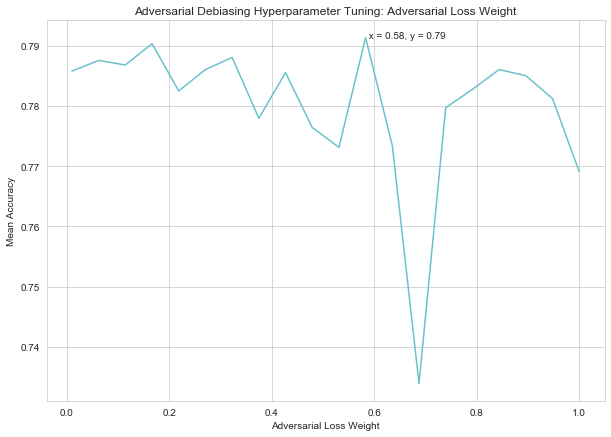

In [105]:
plot_params(param = 'Adversarial Loss Weight', metric = 'Mean Accuracy', 
    param_data = weights, best_x = 0.583158, best_y = 0.791351,
    file_name = 'debiased_params_weights.png',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Adversarial Loss Weight')

**Hyperparameter selection: Number of hidden units**

In [54]:
def find_hidden_units(num_hidden_units):
    units = {'Number of Hidden Units': [], 'Mean Accuracy': []}
    for unit in num_hidden_units:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', classifier_num_hidden_units = unit)
        ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        units['Number of Hidden Units'].append(unit)
        units['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(units)

In [26]:
num_hidden_units = [int(i) for i in np.linspace(1, 250, 20)]
units = find_hidden_units(num_hidden_units = num_hidden_units)

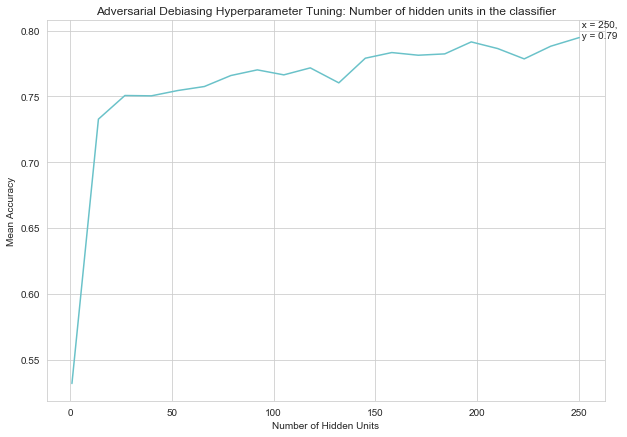

In [109]:
plot_params(param = 'Number of Hidden Units', param_data = units, metric = 'Mean Accuracy',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Number of hidden units in the classifier', 
    file_name = 'debiased_params_units.png', best_x = 250, best_y = 0.794638)

**Training AD model using best performing hyperparameters**

In [279]:
session.close()
tf.reset_default_graph()
session = tf.Session()

In [280]:
ad = AdversarialDebiasing(privileged_groups = privileged_groups, 
    unprivileged_groups = unprivileged_groups, scope_name = 'debiased_classifier', 
    debias = True, sess = session, num_epochs = 100, batch_size = 32,
    classifier_num_hidden_units = 250, adversary_loss_weight = 0.58)
debiased_scaler = StandardScaler()
debiased_train = original_train.copy()
debiased_train.features = debiased_scaler.fit_transform(debiased_train.features)

In [281]:
ad = ad.fit(debiased_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.681617; batch adversarial loss: 0.714069
epoch 1; iter: 0; batch classifier loss: 0.607806; batch adversarial loss: 0.714108
epoch 2; iter: 0; batch classifier loss: 0.588332; batch adversarial loss: 0.688765
epoch 3; iter: 0; batch classifier loss: 0.552301; batch adversarial loss: 0.666473
epoch 4; iter: 0; batch classifier loss: 0.504927; batch adversarial loss: 0.663079
epoch 5; iter: 0; batch classifier loss: 0.662977; batch adversarial loss: 0.691710
epoch 6; iter: 0; batch classifier loss: 0.504459; batch adversarial loss: 0.688672
epoch 7; iter: 0; batch classifier loss: 0.621414; batch adversarial loss: 0.664540
epoch 8; iter: 0; batch classifier loss: 0.475954; batch adversarial loss: 0.673963
epoch 9; iter: 0; batch classifier loss: 0.706383; batch adversarial loss: 0.674392
epoch 10; iter: 0; batch classifier loss: 0.5

**Testing AD model**

In [282]:
debiased_val = original_val.copy()
debiased_val.features = debiased_scaler.transform(debiased_val.features)
y_train_preds_db = ad.predict(debiased_train).scores

In [283]:
bal_acc_arr_ad = []
disp_imp_arr_ad = []
avg_odds_diff_arr_ad = []
stat_par_diff_arr_ad = []
eq_opp_diff_arr_ad = []
theil_ind_arr_ad = []

In [284]:
num_thresh = 100
thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for thresh in tqdm(thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
   
    y_val_preds = (y_train_preds_db[:, pos_ind] > thresh).astype(np.float64)
    debiased_test_preds = debiased_train.copy()
    debiased_test_preds.labels = y_val_preds

    ad_metric_test = compute_metrics(debiased_train, debiased_test_preds, 
        unprivileged_groups, privileged_groups, disp = disp)
    
    bal_acc_arr_ad.append(ad_metric_test['Balanced accuracy'])
    avg_odds_diff_arr_ad.append(ad_metric_test['Average odds difference'])
    disp_imp_arr_ad.append(ad_metric_test['Disparate impact'])
    stat_par_diff_arr_ad.append(ad_metric_test['Statistical parity difference'])
    eq_opp_diff_arr_ad.append(ad_metric_test['Equal opportunity difference'])
    theil_ind_arr_ad.append(ad_metric_test['Theil index'])

  0%|          | 0/100 [00:00<?, ?it/s]invalid value encountered in double_scalars
divide by zero encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 257.00it/s]

Balanced accuracy = 0.3477
Statistical parity difference = 0.1212
Disparate impact = 1.4218
Average odds difference = 0.0872
Equal opportunity difference = 0.0710
Theil index = 0.6035


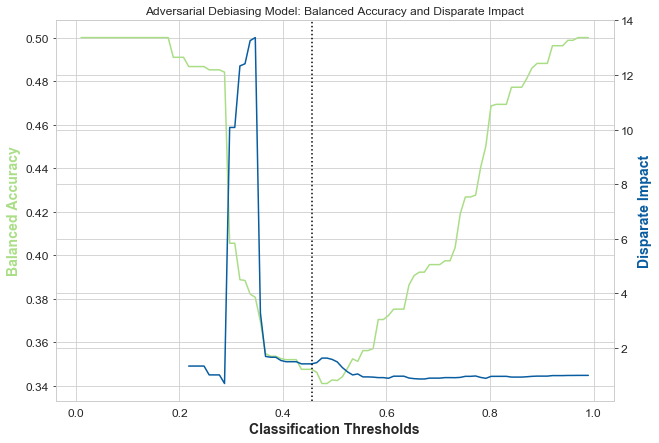

In [285]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_ad, metric_to_plot = disp_imp_arr_ad, 
    metric_name = 'Disparate Impact', line_col = '#085ca0', 
    title = 'Adversarial Debiasing Model: Balanced Accuracy and Disparate Impact', 
    file_name = 'debiased_disp_imp')

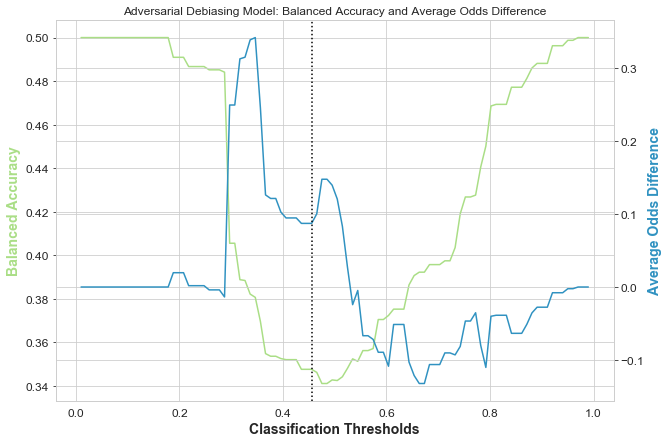

In [286]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_ad, metric_to_plot = avg_odds_diff_arr_ad, 
    metric_name = 'Average Odds Difference', line_col = '#3092c1', 
    title = 'Adversarial Debiasing Model: Balanced Accuracy and Average Odds Difference', 
    file_name = 'debiased_avg_odds_diff')

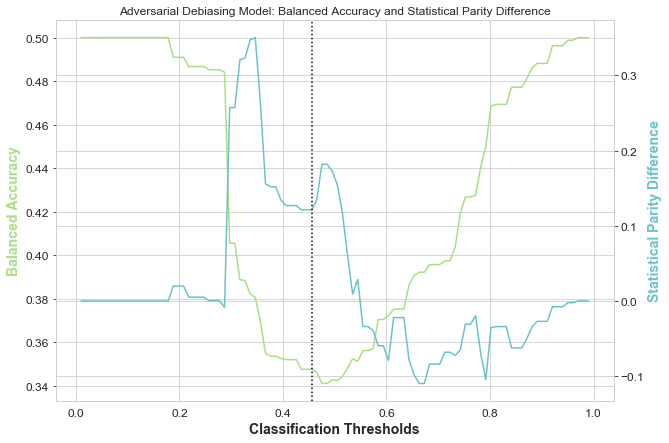

In [287]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_ad, metric_to_plot = stat_par_diff_arr_ad, 
    metric_name = 'Statistical Parity Difference', line_col = '#6ac2c9', 
    title = 'Adversarial Debiasing Model: Balanced Accuracy and Statistical Parity Difference', 
    file_name = 'debiased_stat_par_diff')

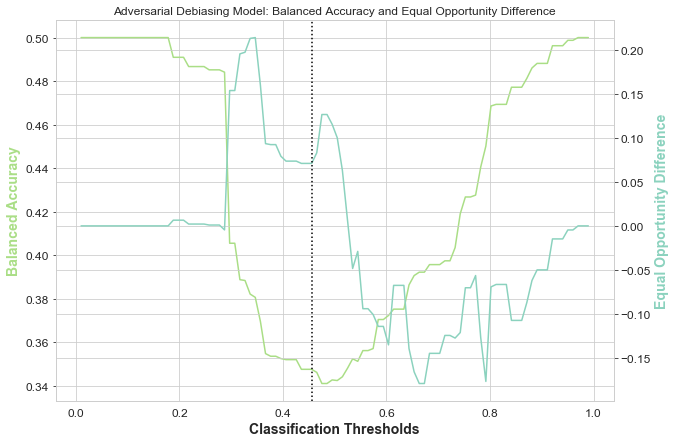

In [288]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_ad, metric_to_plot = eq_opp_diff_arr_ad, 
    metric_name = 'Equal Opportunity Difference', line_col = '#8bd2be', 
    title = 'Adversarial Debiasing Model: Balanced Accuracy and Equal Opportunity Difference', 
    file_name = 'debiased_eq_opp_diff')

In [289]:
debiased_disp_imp = np.interp(best_class_thresh, class_thresh_arr, np.abs(1.0 - np.array(disp_imp_arr_ad)))
debiased_avg_odds_diff = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_ad)
debiased_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr_ad)
debiased_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_ad)
debiased_stat_par_diff = np.interp(best_class_thresh, class_thresh_arr, stat_par_diff_arr_ad)
debiased_eq_opp_diff = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr_ad)
debiased_theil_ind = np.interp(best_class_thresh, class_thresh_arr, theil_ind_arr_ad)

### Prejudice Remover Algorithm

**Defining sensitive attributes for the Prejudice Remover (PR) model**

In [290]:
sens_ind = 0
sens_attr = original_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in original_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in original_train.privileged_protected_attributes[sens_ind]]

In [291]:
pr = PrejudiceRemover(sensitive_attr = sens_attr, eta = 100.0)
pred_scaler = StandardScaler()
pred_train = original_train.copy()
pred_train.features = pred_scaler.fit_transform(pred_train.features)

In [292]:
pr = pr.fit(pred_train)

**Testing PR model**

In [293]:
pred_val = original_val.copy()
pred_val.features = pred_scaler.transform(pred_val.features)
y_train_preds_pr = pr.predict(pred_train).scores

In [294]:
bal_acc_arr_pr = []
disp_imp_arr_pr = []
avg_odds_diff_arr_pr = []
stat_par_diff_arr_pr = []
eq_opp_diff_arr_pr = []
theil_ind_arr_pr = []

In [295]:
num_thresh = 100
thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for thresh in tqdm(thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    y_val_preds = (y_train_preds_pr[:, pos_ind] > thresh).astype(np.float64)
    pred_test_preds = pred_train.copy()
    pred_test_preds.labels = y_val_preds
    
    pr_metric_test = compute_metrics(pred_train, pred_test_preds, 
        unprivileged_groups, privileged_groups, disp = disp)
    
    bal_acc_arr_pr.append(pr_metric_test['Balanced accuracy'])
    avg_odds_diff_arr_pr.append(pr_metric_test['Average odds difference'])
    disp_imp_arr_pr.append(pr_metric_test['Disparate impact'])
    stat_par_diff_arr_pr.append(pr_metric_test['Statistical parity difference'])
    eq_opp_diff_arr_pr.append(pr_metric_test['Equal opportunity difference'])
    theil_ind_arr_pr.append(pr_metric_test['Theil index'])

100%|██████████| 100/100 [00:00<00:00, 292.30it/s]

Balanced accuracy = 0.4826
Statistical parity difference = -0.0261
Disparate impact = 0.9072
Average odds difference = -0.0151
Equal opportunity difference = -0.1406
Theil index = 0.5672


**Displaying results from the classification threshold**

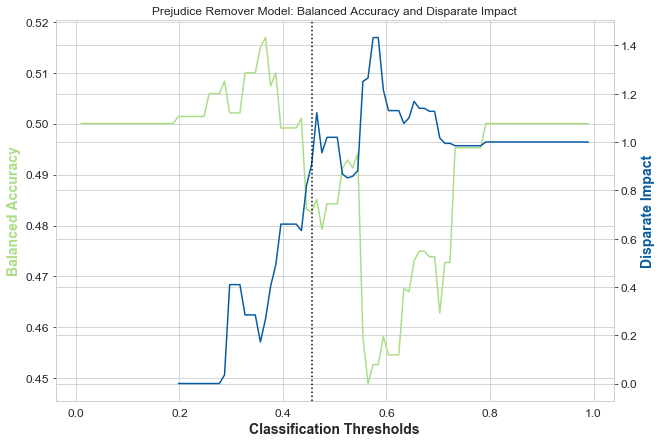

In [296]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_pr, metric_to_plot = disp_imp_arr_pr, 
    metric_name = 'Disparate Impact', line_col = '#085ca0', 
    title = 'Prejudice Remover Model: Balanced Accuracy and Disparate Impact', 
    file_name = 'predremoved_disp_imp')

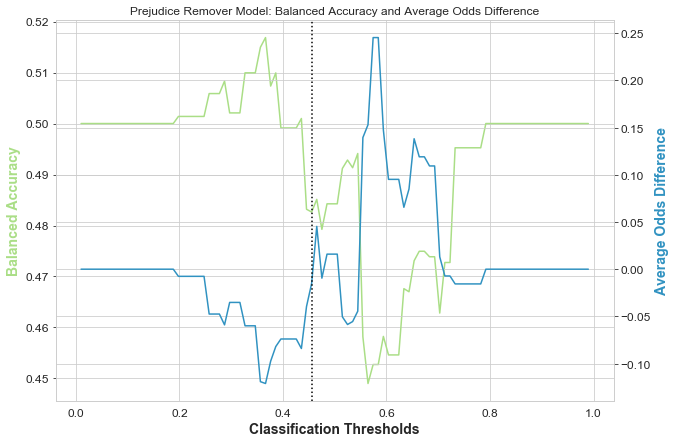

In [297]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_pr, metric_to_plot = avg_odds_diff_arr_pr, 
    metric_name = 'Average Odds Difference', line_col = '#3092c1', 
    title = 'Prejudice Remover Model: Balanced Accuracy and Average Odds Difference', 
    file_name = 'predremoved_avg_odds_diff')

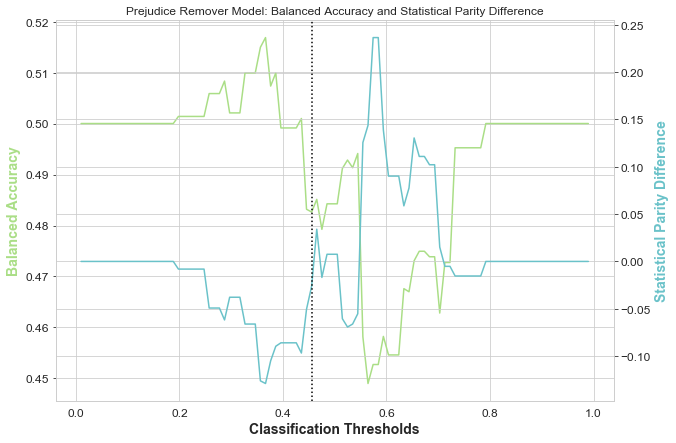

In [298]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_pr, metric_to_plot = stat_par_diff_arr_pr, 
    metric_name = 'Statistical Parity Difference', line_col = '#6ac2c9', 
    title = 'Prejudice Remover Model: Balanced Accuracy and Statistical Parity Difference', 
    file_name = 'predremoved_stat_par_diff')

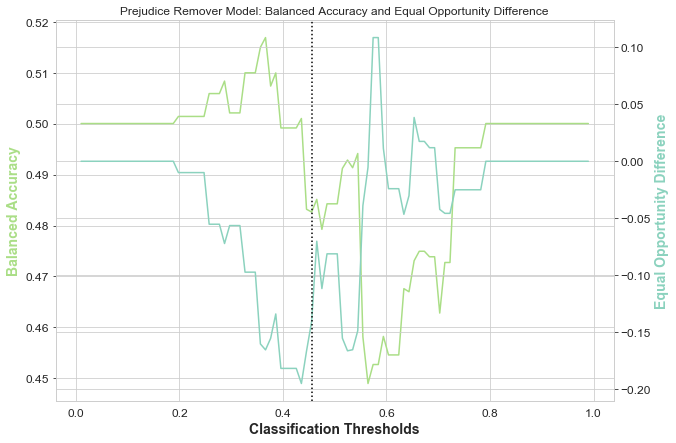

In [299]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_pr, metric_to_plot = eq_opp_diff_arr_pr, 
    metric_name = 'Equal Opportunity Difference', line_col = '#8bd2be', 
    title = 'Prejudice Remover Model: Balanced Accuracy and Equal Opportunity Difference', 
    file_name = 'predremoved_eq_opp_diff')

In [300]:
pred_disp_imp = np.interp(best_class_thresh, class_thresh_arr, np.abs(1.0 - np.array(disp_imp_arr_pr)))
pred_avg_odds_diff = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_pr)
pred_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr_pr)
pred_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_pr)
pred_stat_par_diff = np.interp(best_class_thresh, class_thresh_arr, stat_par_diff_arr_pr)
pred_eq_opp_diff = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr_pr)
pred_theil_ind = np.interp(best_class_thresh, class_thresh_arr, theil_ind_arr_pr)

### Comparing In-processing algorithms

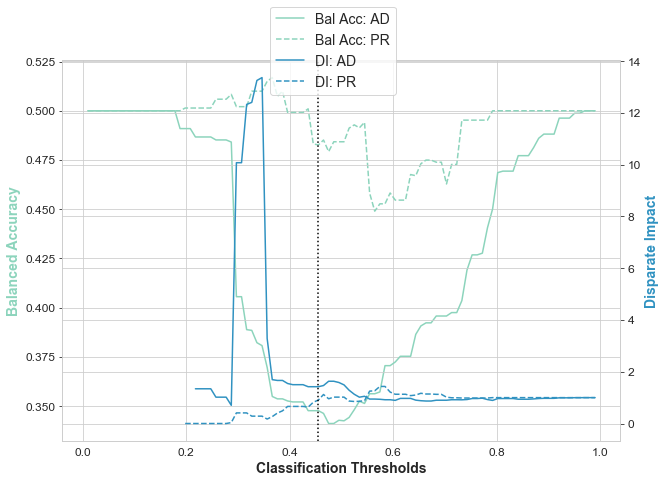

In [302]:
# inprocessing
fig, ax1 = plt.subplots(figsize = (10, 7))
ax1.plot(class_thresh_arr, bal_acc_arr_ad, color = '#8cd4bc')
ax1.plot(class_thresh_arr, bal_acc_arr_pr, color = '#8cd4bc', linestyle = '--')
ax1.set_xlabel('Classification Thresholds', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Balanced Accuracy', color = '#8cd4bc', fontsize = 14, fontweight = 'bold')
ax1.xaxis.set_tick_params(labelsize = 12)
ax1.yaxis.set_tick_params(labelsize = 12)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, disp_imp_arr_ad, color = '#3092c1')
ax2.plot(class_thresh_arr, disp_imp_arr_pr, color = '#3092c1', linestyle = '--')
ax2.set_ylabel('Disparate Impact', color = '#3092c1', fontsize = 14, fontweight = 'bold')
ax2.axvline(best_class_thresh, color = 'k', linestyle = ':')
ax2.yaxis.set_tick_params(labelsize = 12)
ax2.grid(True)

fig.legend(['Bal Acc: AD', 'Bal Acc: PR', 'DI: AD', 'DI: PR'], fontsize = 14, loc = 'upper center')
plt.savefig('inprocessing_comparison.png', bbox_inches = 'tight')

## 6 Applying post-processing techniques: Reject-Option Classification and Calibrated Equalised-Odds Difference

### Reject-Option Classification

**Train LR Classifier**

In [357]:
np.random.seed(1)

In [358]:
original_train, original_val_test = original_dataset.split([0.7], shuffle = True)
original_val, original_test = original_val_test.split([0.5], shuffle = True)

In [359]:
pre_train_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % pre_train_metric.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.127093


In [360]:
original_scaler = StandardScaler()
X_train = original_scaler.fit_transform(original_train.features)
y_train = original_train.labels.ravel()

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_train_preds_pre = lr.predict(X_train)

# positive class index
pos_ind = np.where(lr.classes_ == original_train.favorable_label)[0][0]

pre_train_preds = original_train.copy(deepcopy=True)
pre_train_preds.labels = y_train_preds_pre

In [361]:
pre_val_preds = original_val.copy(deepcopy=True)
X_valid = original_scaler.transform(pre_val_preds.features)
y_valid = pre_val_preds.labels
pre_val_preds.scores = lr.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

pre_test_preds = original_test.copy(deepcopy=True)
X_test = original_scaler.transform(pre_test_preds.features)
y_test = pre_test_preds.labels
pre_test_preds.scores = lr.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [362]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = pre_val_preds.scores > class_thresh
    pre_val_preds.labels[fav_inds] = pre_val_preds.favorable_label
    pre_val_preds.labels[~fav_inds] = pre_val_preds.unfavorable_label
    
    pre_val_classified_metric = ClassificationMetric(original_val,
        pre_val_preds, unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(pre_val_classified_metric.true_positive_rate()\
                       +pre_val_classified_metric.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.6599
Optimal classification threshold (no fairness constraints) = 0.5148


**Hyperparameter selection: Fairness metric to be constrained**

In [365]:
def find_fairness_metric(metric_names):
    metrics = {'Metric': [], 'Optimal Classification Threshold': [], 'ROC Margin': []}
    for metric in metric_names:
        metrics['Metric'].append(metric)
        roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
            privileged_groups = privileged_groups, low_class_thresh = 0.01, 
            high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
            metric_name = metric, metric_ub = 0.05, metric_lb = -0.05)
        roc = roc.fit(original_val, pre_val_preds)
        metrics['Optimal Classification Threshold'].append(roc.classification_threshold)
        metrics['ROC Margin'].append(roc.ROC_margin)
    return pd.DataFrame(metrics)

In [366]:
metric_names = ['Average odds difference', 'Statistical parity difference', 'Equal opportunity difference']
find_fairness_metric(metric_names = metric_names)

,Metric,Optimal Classification Threshold,ROC Margin
0,Average odds difference,0.584141,0.067895
1,Statistical parity difference,0.584141,0.067895
2,Equal opportunity difference,0.584141,0.067895


**Hyperparameter selection: Upper and Lower bounds of the fairness metric constraint**

In [353]:
def find_metric_bounds(upperbounds, lowerbounds):
    bounds = {'Upper Bound': [], 'Lower Bound': [], 'Optimal Classification Threshold': [], 'ROC Margin': [], 'Tradeoff': []}
    for (lower, upper) in [(lower, upper) for lower in lowerbounds for upper in upperbounds]:
        roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
            privileged_groups = privileged_groups, low_class_thresh = 0.01, 
            high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
            metric_name = 'Equal opportunity difference', metric_ub = upper, metric_lb = lower)
        roc = roc.fit(original_val, pre_val_preds)
        bounds['Upper Bound'].append(upper)
        bounds['Lower Bound'].append(lower)
        bounds['Optimal Classification Threshold'].append(roc.classification_threshold)
        bounds['ROC Margin'].append(roc.ROC_margin)
        bounds['Tradeoff'].append(roc.classification_threshold - roc.ROC_margin)
    return pd.DataFrame(bounds)

In [367]:
lowerbounds = [-1, -0.5, -0.1, -0.05, -0.01]
upperbounds = [1, 0.5, 0.1, 0.05, 0.01]
bounds = find_metric_bounds(upperbounds = upperbounds, lowerbounds = lowerbounds)

In [368]:
bounds.head()

,Upper Bound,Lower Bound,Optimal Classification Threshold,ROC Margin,Tradeoff
0,1.00,-1.0,0.554444,0.027279,0.527166
1,0.50,-1.0,0.554444,0.027279,0.527166
2,0.10,-1.0,0.554444,0.027279,0.527166
3,0.05,-1.0,0.554444,0.027279,0.527166
4,0.01,-1.0,0.554444,0.027279,0.527166


In [369]:
# we want to choose fairness metric which maximises the classification threshold while satisfying the fairness constraint, therefore EOD has been chosen
# we want to choose upper and lower bounds that maximises the classification threshold while satisfying the fairness constraint, therefore ub = and lb = has been chosen
roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups, low_class_thresh = 0.01, 
    high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
    metric_name = 'Equal opportunity difference', metric_ub = 0.01, metric_lb = -0.01)
roc = roc.fit(original_val, pre_val_preds)

In [370]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % roc.classification_threshold)
print("Optimal ROC margin = %.4f" % roc.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.5841
Optimal ROC margin = 0.0679


**Predictions from the validation set**

In [371]:
roc_val_preds = roc.predict(pre_val_preds)
display(Markdown('#### Transformed predictions - with fairness constraints'))

post_roc_metric = compute_metrics(original_val, roc_val_preds, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

#### Transformed predictions - with fairness constraints

Balanced accuracy = 0.6646
Statistical parity difference = -0.0471
Disparate impact = 0.9000
Average odds difference = -0.0105
Equal opportunity difference = 0.0002
Theil index = 0.2585


**Predictions from the testing set**

In [372]:
roc_test_preds = roc.predict(pre_test_preds)
display(Markdown('#### Transformed predictions - with fairness constraints'))

post_roc_metric = compute_metrics(original_test, roc_test_preds, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

#### Transformed predictions - with fairness constraints

Balanced accuracy = 0.6512
Statistical parity difference = 0.0578
Disparate impact = 1.1356
Average odds difference = 0.1145
Equal opportunity difference = 0.1196
Theil index = 0.2610


In [373]:
bal_acc_arr_roc = []
disp_imp_arr_roc = []
avg_odds_diff_arr_roc = []
stat_par_diff_arr_roc = []
eq_opp_diff_arr_roc = []
theil_ind_arr_roc = []

In [374]:
num_thresh = 100
thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for thresh in tqdm(thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    fav_inds = pre_test_preds.scores > best_class_thresh
    pre_test_preds.labels[fav_inds] = pre_test_preds.favorable_label
    pre_test_preds.labels[~fav_inds] = pre_test_preds.unfavorable_label
    post_test_preds = roc.predict(pre_test_preds)

    post_roc_metric = compute_metrics(original_test, post_test_preds, 
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups,
        disp = disp)

    bal_acc_arr_roc.append(post_roc_metric['Balanced accuracy'])
    avg_odds_diff_arr_roc.append(post_roc_metric['Average odds difference'])
    disp_imp_arr_roc.append(post_roc_metric['Disparate impact'])
    stat_par_diff_arr_roc.append(post_roc_metric['Statistical parity difference'])
    eq_opp_diff_arr_roc.append(post_roc_metric['Equal opportunity difference'])
    theil_ind_arr_roc.append(post_roc_metric['Theil index'])

100%|██████████| 100/100 [00:00<00:00, 395.68it/s]

Balanced accuracy = 0.6512
Statistical parity difference = 0.0578
Disparate impact = 1.1356
Average odds difference = 0.1145
Equal opportunity difference = 0.1196
Theil index = 0.2610


In [375]:
# num_thresh = 100
# thresh_arr = np.linspace(0.01, 0.99, num_thresh)

# roc_test_preds = roc.predict(original_test_preds)

# for thresh in tqdm(thresh_arr):
#     if thresh == best_class_thresh:
#         disp = True
#     else:
#         disp = False
   
#     fav_inds = roc_test_preds.scores > thresh

#     # roc_test_preds.labels[fav_inds] = roc_test_preds.favorable_label
#     # roc_test_preds.labels[~fav_inds] = roc_test_preds.unfavorable_label

#     post_roc_metric = compute_metrics(original_test, roc_test_preds, 
#         unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

#     bal_acc_arr_roc.append(post_roc_metric['Balanced accuracy'])
#     avg_odds_diff_arr_roc.append(post_roc_metric['Average odds difference'])
#     disp_imp_arr_roc.append(post_roc_metric['Disparate impact'])
#     stat_par_diff_arr_roc.append(post_roc_metric['Statistical parity difference'])
#     eq_opp_diff_arr_roc.append(post_roc_metric['Equal opportunity difference'])
#     theil_ind_arr_roc.append(post_roc_metric['Theil index'])

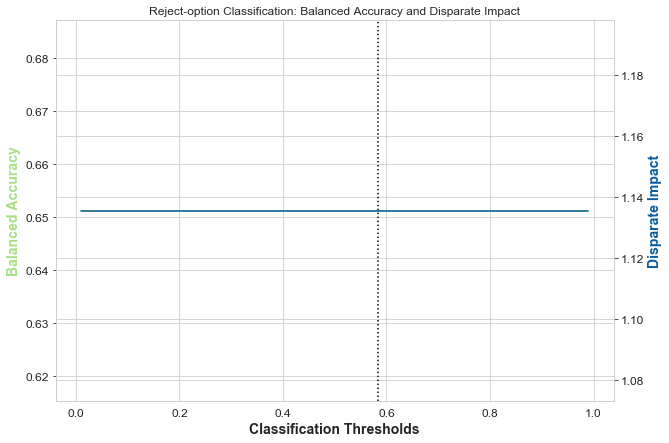

In [376]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = roc.classification_threshold, 
    balanced_acc = bal_acc_arr_roc, metric_to_plot = disp_imp_arr_roc, 
    metric_name = 'Disparate Impact', line_col = '#085ca0', 
    title = 'Reject-option Classification: Balanced Accuracy and Disparate Impact',
    file_name = 'roc_disp_imp')

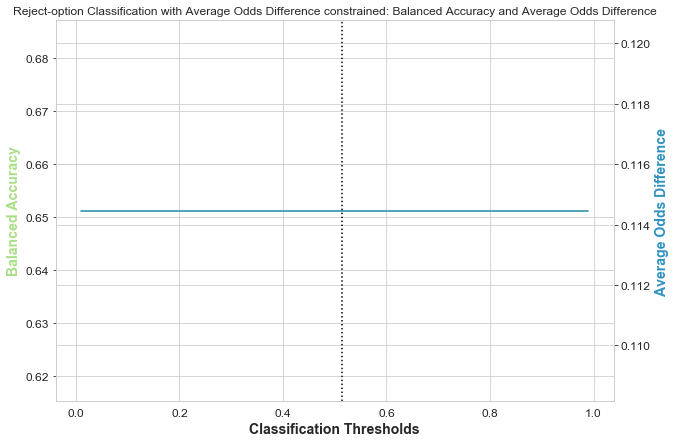

In [377]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_roc, metric_to_plot = avg_odds_diff_arr_roc, 
    metric_name = 'Average Odds Difference', line_col = '#3092c1', 
    title = 'Reject-option Classification with Average Odds Difference constrained: Balanced Accuracy and Average Odds Difference', 
    file_name = 'roc_avg_odds_diff')

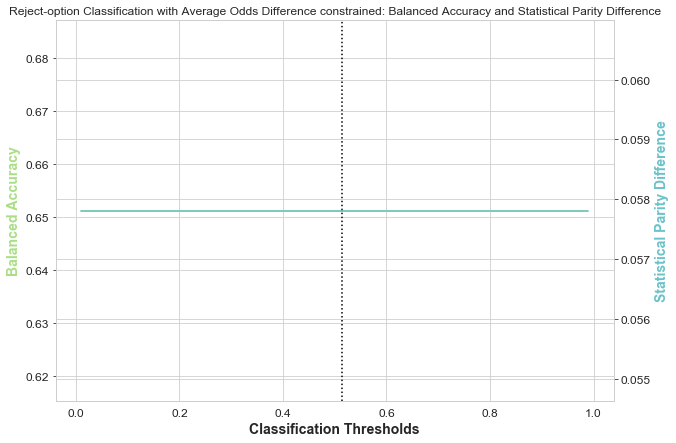

In [378]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_roc, metric_to_plot = stat_par_diff_arr_roc, 
    metric_name = 'Statistical Parity Difference', line_col = '#6ac2c9', 
    title = 'Reject-option Classification with Average Odds Difference constrained: Balanced Accuracy and Statistical Parity Difference',
    file_name = 'roc_stat_par_diff')

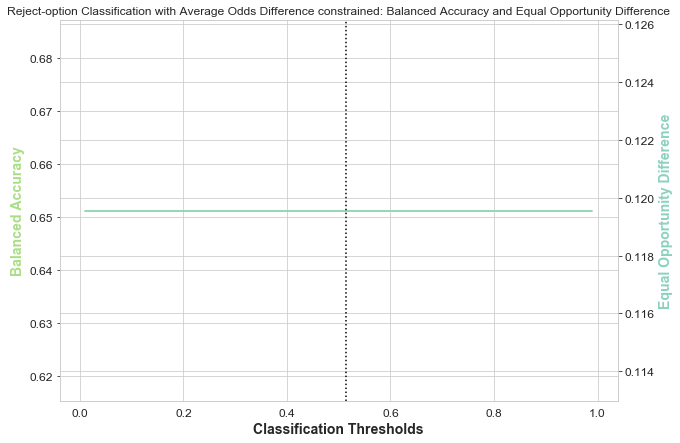

In [379]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr_roc, metric_to_plot = eq_opp_diff_arr_roc, 
    metric_name = 'Equal Opportunity Difference', line_col = '#8bd2be', 
    title = 'Reject-option Classification with Average Odds Difference constrained: Balanced Accuracy and Equal Opportunity Difference', 
    file_name = 'roc_eq_opp_diff')

In [380]:
roc_disp_imp = np.interp(best_class_thresh, class_thresh_arr, disp_imp_arr_roc)
roc_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_roc)
roc_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr_roc)
roc_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr_roc)
roc_stat_par_diff = np.interp(best_class_thresh, class_thresh_arr, stat_par_diff_arr_roc)
roc_eq_opp_diff = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr_roc)
roc_theil_ind = np.interp(best_class_thresh, class_thresh_arr, theil_ind_arr_roc)


### Calibrated Equalized-Odds Difference

**Creating predicted and transformed datasets**

In [138]:
pre_train_preds = original_train.copy(deepcopy = True)
pre_val_preds = original_val.copy(deepcopy = True)
pre_test_preds = original_test.copy(deepcopy = True)

post_val_pred = pre_val_preds.copy(deepcopy = True)
post_test_pred = pre_test_preds.copy(deepcopy = True)

**Retraining an LR classifier**

In [139]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

In [140]:
original_scale = StandardScaler()
X_train_pre = original_scale.fit_transform(original_train.features)
y_train_pre = original_train.labels.ravel()

In [141]:
lr = LogisticRegression()
lr.fit(X_train_pre, y_train_pre)

LogisticRegression()

In [142]:
class_thresh = 0.5

**Predicting probabilities for training, validation and testing datasets**

In [143]:
fav_idx = np.where(lr.classes_ == original_train.favorable_label)[0][0]

y_train_pred_probs = lr.predict_proba(X_train_pre)[:, fav_idx]
pre_train_preds.scores = y_train_pred_probs.reshape(-1, 1)

X_valid_pre = original_scale.transform(original_val.features)
y_val_pred_probs = lr.predict_proba(X_valid_pre)[:, fav_idx]
pre_val_preds.scores = y_val_pred_probs.reshape(-1, 1)

X_test_pre = original_scale.transform(original_test.features)
y_test_pred_probs = lr.predict_proba(X_test_pre)[:, fav_idx]
pre_test_preds.scores = y_test_pred_probs.reshape(-1, 1)

In [144]:
y_train_preds_pre = np.zeros_like(pre_train_preds.labels)
y_train_preds_pre[y_train_pred_probs >= class_thresh] = pre_train_preds.favorable_label
y_train_preds_pre[~(y_train_pred_probs >= class_thresh)] = pre_train_preds.unfavorable_label
pre_train_preds.labels = y_train_preds_pre

y_val_preds_pre = np.zeros_like(pre_val_preds.labels)
y_val_preds_pre[y_val_pred_probs >= class_thresh] = pre_val_preds.favorable_label
y_val_preds_pre[~(y_val_pred_probs >= class_thresh)] = pre_val_preds.unfavorable_label
pre_val_preds.labels = y_val_preds_pre

y_test_preds_pre = np.zeros_like(pre_test_preds.labels)
y_test_preds_pre[y_test_pred_probs >= class_thresh] = pre_test_preds.favorable_label
y_test_preds_pre[~(y_test_pred_probs >= class_thresh)] = pre_test_preds.unfavorable_label
pre_test_preds.labels = y_test_preds_pre

In [178]:
display(Markdown('#### Original training dataset predictions'))
pre_train_metric = ClassificationMetric(original_train, pre_train_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
print('Difference in generalised false positive rate between unprivileged and privileged groups: %f' 
    % pre_train_metric.difference(pre_train_metric.generalized_false_positive_rate))
print('Difference in generalised false negative rate between unprivileged and privileged groups: %f' 
    % pre_train_metric.difference(pre_train_metric.generalized_false_negative_rate))

display(Markdown('#### Original validation dataset predictions'))
pre_val_metric = ClassificationMetric(original_val, pre_val_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
print('Difference in generalised false positive rate between unprivileged and privileged groups: %f' 
    % pre_val_metric.difference(pre_val_metric.generalized_false_positive_rate))
print('Difference in generalised false negative rate between unprivileged and privileged groups: %f' 
    % pre_val_metric.difference(pre_val_metric.generalized_false_negative_rate))

display(Markdown('#### Original testing dataset predictions'))
pre_test_metric = ClassificationMetric(original_test, pre_test_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
print('Difference in generalised false positive rate between unprivileged and privileged groups: %f' 
    % pre_test_metric.difference(pre_test_metric.generalized_false_positive_rate))
print('Difference in generalised false negative rate between unprivileged and privileged groups: %f' 
    % pre_test_metric.difference(pre_test_metric.generalized_false_negative_rate))

#### Original training dataset predictions

Difference in generalised false positive rate between unprivileged and privileged groups: -0.113462
Difference in generalised false negative rate between unprivileged and privileged groups: 0.103943


#### Original validation dataset predictions

Difference in generalised false positive rate between unprivileged and privileged groups: -0.127772
Difference in generalised false negative rate between unprivileged and privileged groups: 0.108856


#### Original testing dataset predictions

Difference in generalised false positive rate between unprivileged and privileged groups: -0.114524
Difference in generalised false negative rate between unprivileged and privileged groups: 0.107857


**Setting the cost constraint**
- Setting the cost constraint to *FNR* will optimise the generalised False Negative Rates
- Setting the cost constraint to *FPR* will optimise the generalised False Positive Rates
- Setting the cost constraint to *Weighted* will optimise a weighed combination of False Negative and False Positive Rates

**Learning the parameters to Equalise Odds**

In [216]:
def get_cost_constraint(constraints, dataset):
    validation_constraints = {'Cost Constraint': [], 'Difference in GFPR': [], 'Difference in GFNR': []}
    testing_constraints = {'Cost Constraint': [], 'Difference in GFPR': [], 'Difference in GFNR': []}
    if dataset == 'Validation':
        for constraint in constraints:
            ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, unprivileged_groups = unprivileged_groups, 
            cost_constraint = constraint, seed = 12345679)
            ceo.fit(original_val, pre_val_preds)
            transf_val_preds = ceo.predict(pre_val_preds)
            post_val_metric = ClassificationMetric(pre_val_preds, transf_val_preds, unprivileged_groups = unprivileged_groups, 
                privileged_groups = privileged_groups)
            validation_constraints['Cost Constraint'].append(constraint)
            validation_constraints['Difference in GFPR'].append(post_val_metric.difference(post_val_metric.generalized_false_positive_rate))
            validation_constraints['Difference in GFNR'].append(post_val_metric.difference(post_val_metric.generalized_false_negative_rate))
        return pd.DataFrame(validation_constraints)
    elif dataset == 'Testing':
        for constraint in constraints:
            ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, unprivileged_groups = unprivileged_groups, 
            cost_constraint = constraint, seed = 12345679)
            ceo.fit(original_test, pre_test_preds)
            transf_test_preds = ceo.predict(pre_test_preds)
            post_test_metric = ClassificationMetric(pre_test_preds, transf_test_preds, unprivileged_groups = unprivileged_groups, 
                privileged_groups = privileged_groups)
            testing_constraints['Cost Constraint'].append(constraint)
            testing_constraints['Difference in GFPR'].append(post_test_metric.difference(post_test_metric.generalized_false_positive_rate))
            testing_constraints['Difference in GFNR'].append(post_test_metric.difference(post_test_metric.generalized_false_negative_rate))       
        return pd.DataFrame(testing_constraints)

In [217]:
constraints = ['fpr', 'fnr', 'weighted']
get_cost_constraint(constraints = constraints, dataset = 'Validation')

,Cost Constraint,Difference in GFPR,Difference in GFNR
0,fpr,0.083529,0.226972
1,fnr,-0.277785,-0.011774
2,weighted,-0.106938,0.039131


In [218]:
get_cost_constraint(constraints = constraints, dataset = 'Testing')

,Cost Constraint,Difference in GFPR,Difference in GFNR
0,fpr,0.074455,0.256397
1,fnr,-0.251866,-0.030297
2,weighted,-0.080652,0.046030


In [219]:
ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, 
    unprivileged_groups = unprivileged_groups, cost_constraint = 'weighted')
ceo.fit(original_val, original_val_preds)

In [220]:
transf_val_preds = ceo.predict(pre_val_preds)
transf_test_preds = ceo.predict(pre_test_preds)

In [221]:
post_val_metric = ClassificationMetric(pre_val_preds, transf_val_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
post_test_metric = ClassificationMetric(pre_test_preds, transf_test_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [195]:
assert np.abs(post_val_metric.difference(post_val_metric.generalized_false_negative_rate)) \
    < np.abs(pre_val_metric.difference(pre_val_metric.generalized_false_negative_rate)) 

In [215]:
assert np.abs(post_test_metric.difference(post_test_metric.generalized_false_negative_rate)) \
    < np.abs(pre_test_metric.difference(pre_test_metric.generalized_false_negative_rate)) 

In [223]:
num_thresh = 100
all_threshs = np.linspace(0.01, 0.99, num_thresh)

In [224]:
pre_avg_odds_diff_test = []
pre_avg_odds_diff_val = []
post_avg_odds_diff_test = []
post_avg_odds_diff_val = []

pre_bal_acc_test = []
pre_bal_acc_val = []
post_bal_acc_test = []
post_bal_acc_val = []

pre_disp_imp_test = []
pre_disp_imp_val = []
post_disp_imp_test = []
post_disp_imp_val = []

pre_stat_par_diff_test = []
pre_stat_par_diff_val = []
post_stat_par_diff_test = []
post_stat_par_diff_val = []

pre_eq_opp_diff_test = []
pre_eq_opp_diff_val = []
post_eq_opp_diff_test = []
post_eq_opp_diff_val = []

pre_theil_ind_test = []
pre_theil_ind_val = []
post_theil_ind_test = []
post_theil_ind_val = []

In [225]:
for thresh in tqdm(all_threshs):
    orig_val_preds_thresh = pre_val_preds.copy(deepcopy = True)
    orig_test_preds_thresh = pre_test_preds.copy(deepcopy = True)

    transf_val_preds_thresh = transf_val_preds.copy(deepcopy = True)
    transf_test_preds_thresh = transf_test_preds.copy(deepcopy = True)

    # labels for the original datasets from scores 
    y_temp = np.zeros_like(orig_val_preds_thresh.labels)
    y_temp[orig_val_preds_thresh.scores >= thresh] = orig_val_preds_thresh.favorable_label
    y_temp[~(orig_val_preds_thresh.scores >= thresh)] = orig_val_preds_thresh.unfavorable_label
    orig_val_preds_thresh.labels = y_temp

    y_temp = np.zeros_like(orig_test_preds_thresh.labels)
    y_temp[orig_test_preds_thresh.scores >= thresh] = orig_test_preds_thresh.favorable_label
    y_temp[~(orig_test_preds_thresh.scores >= thresh)] = orig_test_preds_thresh.unfavorable_label
    orig_test_preds_thresh.labels = y_temp

    # labels for the transformed datasets from scores
    y_temp = np.zeros_like(transf_val_preds_thresh.labels)
    y_temp[transf_val_preds_thresh.scores >= thresh] = transf_val_preds_thresh.favorable_label
    y_temp[~(transf_val_preds_thresh.scores >= thresh)] = transf_val_preds_thresh.unfavorable_label
    transf_val_preds_thresh.labels = y_temp

    y_temp = np.zeros_like(transf_test_preds_thresh.labels)
    y_temp[transf_test_preds_thresh.scores >= thresh] = transf_test_preds_thresh.favorable_label
    y_temp[~(transf_test_preds_thresh.scores >= thresh)] = transf_test_preds_thresh.unfavorable_label
    transf_test_preds_thresh.labels = y_temp

    # metrics for the original datasets 
    orig_val_metric = ClassificationMetric(original_val, orig_val_preds_thresh, 
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
    pre_avg_odds_diff_val.append(orig_val_metric.equal_opportunity_difference())
    pre_bal_acc_val.append(0.5 * (orig_val_metric.true_positive_rate() + orig_val_metric.true_negative_rate()))
    pre_disp_imp_val.append(orig_val_metric.disparate_impact())
    pre_stat_par_diff_val.append(orig_val_metric.statistical_parity_difference())
    pre_eq_opp_diff_val.append(orig_val_metric.equal_opportunity_difference())
    pre_theil_ind_val.append(orig_val_metric.theil_index())

    orig_test_metric = ClassificationMetric(original_test, orig_test_preds_thresh,
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
    pre_avg_odds_diff_test.append(orig_test_metric.equal_opportunity_difference())
    pre_bal_acc_test.append(0.5 * (orig_test_metric.true_positive_rate() + orig_test_metric.true_negative_rate()))
    pre_disp_imp_test.append(orig_test_metric.disparate_impact())
    pre_stat_par_diff_test.append(orig_test_metric.statistical_parity_difference())
    pre_eq_opp_diff_test.append(orig_test_metric.equal_opportunity_difference())
    pre_theil_ind_test.append(orig_test_metric.theil_index())

    # metrics for the transformed datasets 
    transf_val_metric = ClassificationMetric(original_val, transf_val_preds_thresh, 
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
    post_avg_odds_diff_val.append(transf_val_metric.equal_opportunity_difference())
    post_bal_acc_val.append(0.5 * (transf_val_metric.true_positive_rate() + transf_val_metric.true_negative_rate()))
    post_disp_imp_val.append(transf_val_metric.disparate_impact())
    post_stat_par_diff_val.append(transf_val_metric.statistical_parity_difference())
    post_eq_opp_diff_val.append(transf_val_metric.equal_opportunity_difference())
    post_theil_ind_val.append(transf_val_metric.theil_index())

    transf_test_metric = ClassificationMetric(original_test, transf_test_preds_thresh, 
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
    post_avg_odds_diff_test.append(transf_test_metric.equal_opportunity_difference())
    post_bal_acc_test.append(0.5 * (transf_test_metric.true_positive_rate() + transf_test_metric.true_negative_rate()))
    post_disp_imp_test.append(transf_test_metric.disparate_impact())
    post_stat_par_diff_test.append(transf_test_metric.statistical_parity_difference())
    post_eq_opp_diff_test.append(transf_test_metric.equal_opportunity_difference())
    post_theil_ind_test.append(transf_test_metric.theil_index())

100%|██████████| 100/100 [00:03<00:00, 31.68it/s]


In [228]:
post_avg_odds_diff_test = np.array(post_avg_odds_diff_test)
post_bal_acc_test = np.array(post_bal_acc_test)
post_disp_imp_test = np.array(post_disp_imp_test)
post_stat_par_diff_test = np.array(post_stat_par_diff_test)
post_eq_opp_diff_test = np.array(post_eq_opp_diff_test)
post_theil_ind_test = np.array(post_theil_ind_test)

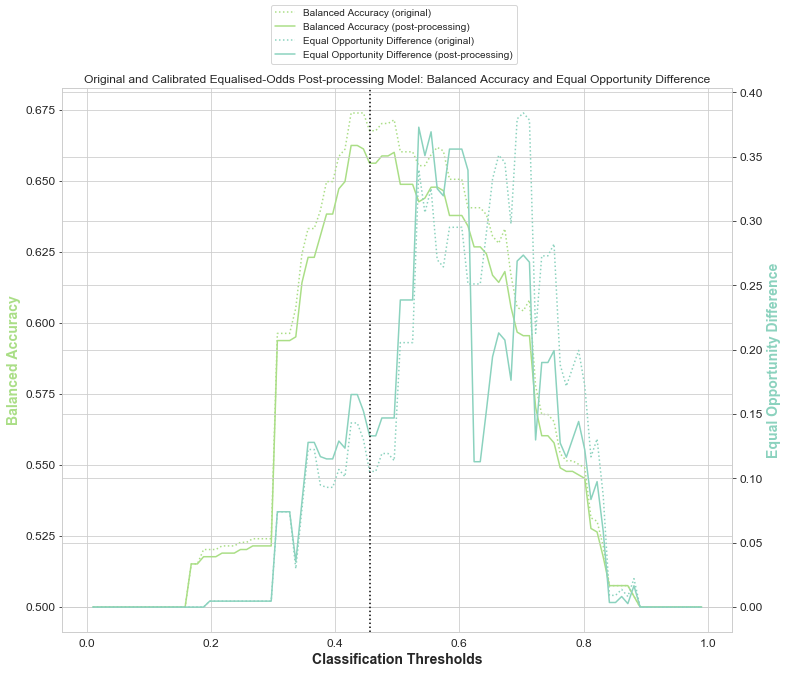

In [233]:
fig, ax1 = plt.subplots(figsize = (12, 10))
ax1.plot(all_threshs, pre_bal_acc_test, color = '#aade86', linestyle = ':')
ax1.plot(all_threshs, post_bal_acc_test, color = '#aade86')
ax1.set_xlabel('Classification Thresholds', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Balanced Accuracy', color = '#aade86', fontsize = 14, fontweight = 'bold')
ax1.xaxis.set_tick_params(labelsize = 12)
ax1.yaxis.set_tick_params(labelsize = 12)

ax2 = ax1.twinx()
ax2.plot(all_threshs, np.abs(pre_eq_opp_diff_test), color = '#8bd2be', linestyle = ':')
ax2.plot(all_threshs, np.abs(post_eq_opp_diff_test), color = '#8bd2be')
ax2.set_ylabel('Equal Opportunity Difference', color = '#8bd2be', fontsize = 14, fontweight = 'bold')
ax2.axvline(best_class_thresh, color = 'k', linestyle = ':')
ax2.yaxis.set_tick_params(labelsize = 12)
ax2.grid(True)

fig.legend(['Balanced Accuracy (original)', 'Balanced Accuracy (post-processing)', 'Equal Opportunity Difference (original)', 'Equal Opportunity Difference (post-processing)'], loc = 'upper center')
plt.title('Original and Calibrated Equalised-Odds Post-processing Model: Balanced Accuracy and Equal Opportunity Difference')
plt.savefig('calibrated_odds_diff_comp.png', bbox_inches = 'tight')

In [234]:
disp_imp_arr_ceo = np.interp(best_class_thresh, all_threshs, post_disp_imp_test)
avg_odds_diff_arr_ceo = np.interp(best_class_thresh, all_threshs, post_avg_odds_diff_test)
bal_acc_arr_ceo = np.interp(best_class_thresh, all_threshs, post_bal_acc_test)
stat_par_diff_arr_ceo = np.interp(best_class_thresh, all_threshs, post_stat_par_diff_test)
eq_opp_diff_arr_ceo = np.interp(best_class_thresh, all_threshs, post_eq_opp_diff_test)
theil_ind_arr_ceo = np.interp(best_class_thresh, all_threshs, post_theil_ind_test)

### Comparing post-processing algorithms

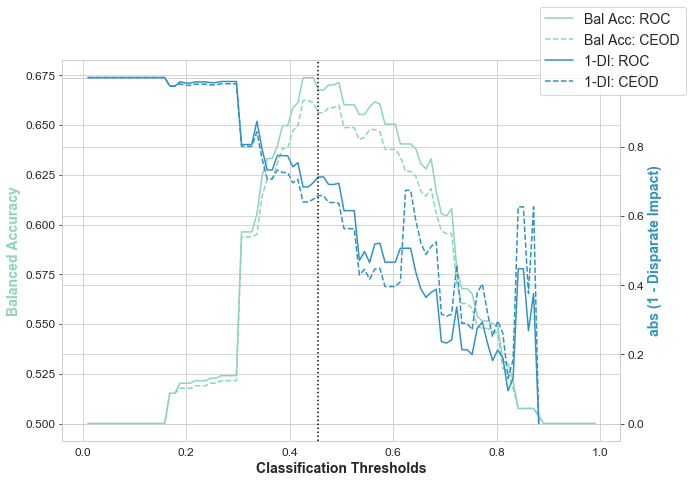

In [248]:
# post-processing
fig, ax1 = plt.subplots(figsize = (10, 7))
ax1.plot(class_thresh_arr, bal_acc_arr_roc, color = '#8cd4bc')
ax1.plot(class_thresh_arr, post_bal_acc_test, color = '#8cd4bc', linestyle = '--')
ax1.set_xlabel('Classification Thresholds', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Balanced Accuracy', color = '#8cd4bc', fontsize = 14, fontweight = 'bold')
ax1.xaxis.set_tick_params(labelsize = 12)
ax1.yaxis.set_tick_params(labelsize = 12)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, disp_imp_arr_roc, color = '#3092c1')
ax2.plot(class_thresh_arr, post_disp_imp_test, color = '#3092c1', linestyle = '--')
ax2.set_ylabel('abs (1 - Disparate Impact)', color = '#3092c1', fontsize = 14, fontweight = 'bold')
ax2.axvline(best_class_thresh, color = 'k', linestyle = ':')
ax2.yaxis.set_tick_params(labelsize = 12)
ax2.grid(True)
# fig.legend(['Balanced Accuracy - Reject Option Classification', '1-Disparate Impact - Reject Option Classification', 'Balanced Accuracy - Calibrated Equalised-Odds', '1-Disparate Impact - Calibrated Equalised-Odds'], 
#     fontsize = 14, loc = 'upper center', bbox_to_anchor = (0.5, 1.05))
fig.legend(['Bal Acc: ROC', 'Bal Acc: CEOD', '1-DI: ROC', '1-DI: CEOD'], fontsize = 14, loc = 'upper right')
plt.savefig('postprocessing_comparison.png', bbox_inches = 'tight')

## 7 Results

In [382]:
comp_results = {'Processing': ['', 'Pre-Processing', 'In-Processing', '', 'Post-Processing', ''],
    'Bias Mitigator': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-Option Classification', 'Calibrated Equalised-Odds'],
    'Balanced Accuracy': [original_bal_acc, reweighed_bal_acc, debiased_bal_acc, pred_bal_acc, roc_bal_acc, bal_acc_arr_ceo],
    '1 - Disparate Impact': [original_disp_imp, reweighed_disp_imp, debiased_disp_imp, pred_disp_imp, (1 - roc_disp_imp), (1 - disp_imp_arr_ceo)],
    'Disparate Impact': [(1 - original_disp_imp), (1 - reweighed_disp_imp), (1 - debiased_disp_imp), (1 - pred_disp_imp), (roc_disp_imp), (disp_imp_arr_ceo)],
    'Average Odds Difference': [original_avg_odds, reweighed_avg_odds, debiased_avg_odds_diff, pred_avg_odds_diff, roc_avg_odds, avg_odds_diff_arr_ceo],
    'Equal Opportunity Difference': [original_eq_opp_diff, reweighed_eq_opp_diff, debiased_avg_odds_diff, pred_eq_opp_diff, roc_eq_opp_diff, eq_opp_diff_arr_ceo],
    'Statistical Parity Difference': [original_stat_par_diff, reweighed_stat_par_diff, debiased_stat_par_diff, pred_stat_par_diff, roc_stat_par_diff, stat_par_diff_arr_ceo],
    'Theil Index': [original_theil_ind, reweighed_theil_ind, debiased_theil_ind, pred_theil_ind, roc_theil_ind, theil_ind_arr_ceo]}
comp_results = pd.DataFrame(data = comp_results)
comp_results

,Processing,Bias Mitigator,Balanced Accuracy,1 - Disparate Impact,Disparate Impact,Average Odds Difference,Equal Opportunity Difference,Statistical Parity Difference,Theil Index
0,,Logistic Regression,0.667612,0.712667,0.287333,-0.177208,-0.105458,-0.218561,0.163832
1,Pre-Processing,Reweighing,0.658712,0.119106,0.880894,-0.039944,0.003555,-0.083570,0.156656
2,In-Processing,Adversarial Debiasing,0.347679,0.421774,0.578226,0.087167,0.087167,0.121157,0.603452
3,,Prejudice Remover,0.482643,0.092816,0.907184,-0.015064,-0.140610,-0.026099,0.567165
4,Post-Processing,Reject-Option Classification,0.651227,-0.135602,1.135602,0.114463,0.119558,0.057811,0.260994
5,,Calibrated Equalised-Odds,0.656187,0.341280,0.658720,-0.133083,-0.133083,-0.280856,0.158180


In [304]:
alg_results = comp_results.to_json()
with open('algorithm_results.json', 'w') as fp:
    json.dump(alg_results, fp)

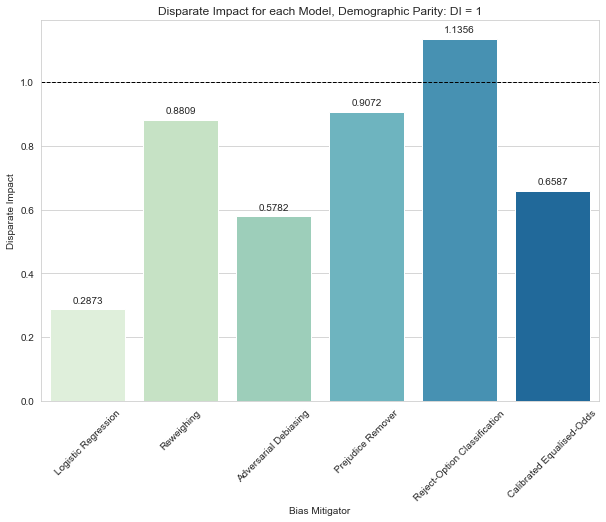

In [383]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Bias Mitigator', y = 'Disparate Impact', data = comp_results, palette = 'GnBu')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
ax.axhline(1.0, color = '#000000', linewidth = 1, linestyle = '--')
plt.title('Disparate Impact for each Model, Demographic Parity: DI = 1')
plt.xticks(rotation = 45)
plt.savefig('disp_imp_comp.png', bbox_inches = 'tight')

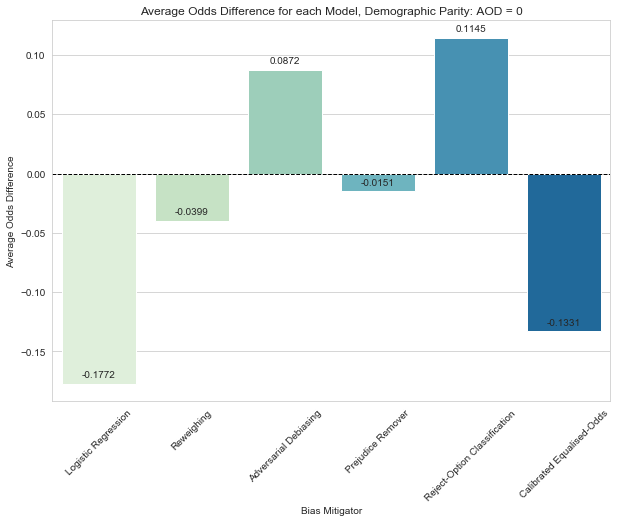

In [384]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Bias Mitigator', y = 'Average Odds Difference', data = comp_results, palette = 'GnBu')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
ax.axhline(0.0, color = '#000000', linewidth = 1, linestyle = '--')
plt.title('Average Odds Difference for each Model, Demographic Parity: AOD = 0')
plt.xticks(rotation = 45)
plt.savefig('avg_odds_diff_comp.png', bbox_inches = 'tight')

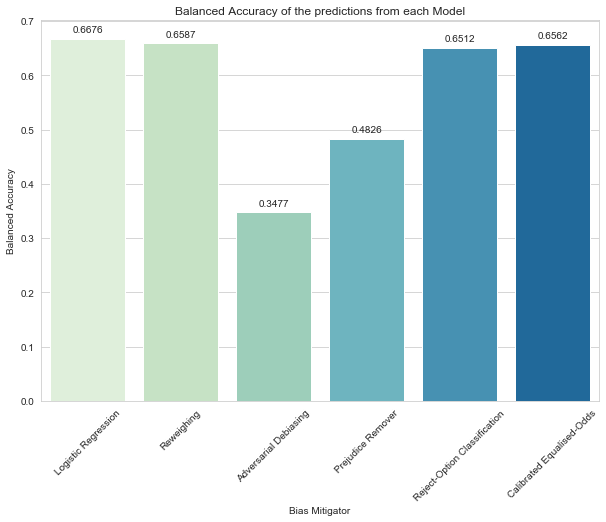

In [385]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Bias Mitigator', y = 'Balanced Accuracy', data = comp_results, palette = 'GnBu')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
# ax.axhline(1.0, color = '#000000', linewidth = 1, linestyle = '--')
plt.xticks(rotation = 45)
plt.title('Balanced Accuracy of the predictions from each Model')
plt.savefig('bal_acc_comp.png', bbox_inches = 'tight')

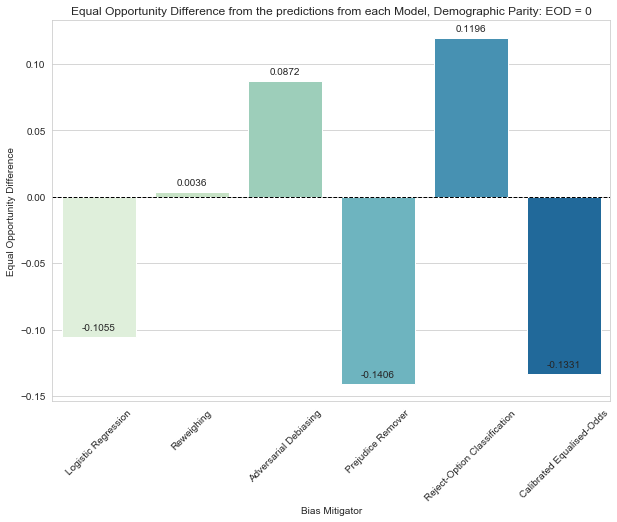

In [386]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Bias Mitigator', y = 'Equal Opportunity Difference', data = comp_results, palette = 'GnBu')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
ax.axhline(0.0, color = '#000000', linewidth = 1, linestyle = '--')
ax.axhline(0.1, color = '#000000', linewidth = 1, linestyle = '')
plt.xticks(rotation = 45)
plt.title('Equal Opportunity Difference from the predictions from each Model, Demographic Parity: EOD = 0')
plt.savefig('eq_opp_diff_comp.png', bbox_inches = 'tight')

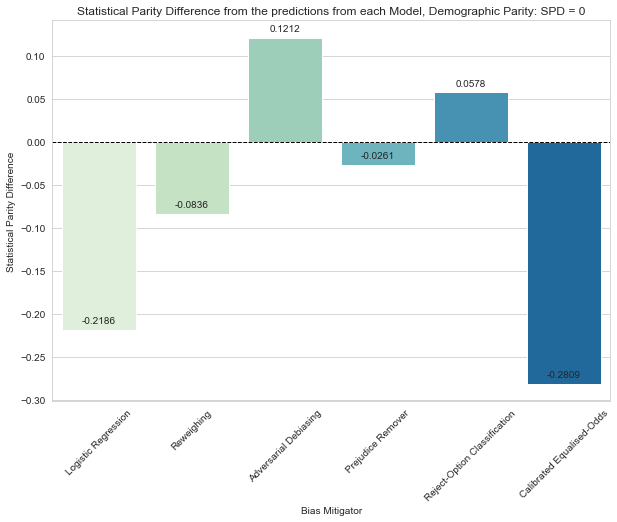

In [387]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Bias Mitigator', y = 'Statistical Parity Difference', data = comp_results, palette = 'GnBu')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
ax.axhline(0.0, color = '#000000', linewidth = 1, linestyle = '--')
plt.xticks(rotation = 45)
plt.title('Statistical Parity Difference from the predictions from each Model, Demographic Parity: SPD = 0')
plt.savefig('stat_par_diff_comp.png', bbox_inches = 'tight')

## 8 Using results to build a new model - Reweighing, Gerry Fair & Reject-option

**Pre-processing data using Reweighing**

In [410]:
preprocessor = Reweighing(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
preprocessor.fit(original_train)
preprocessed = preprocessor.transform(original_train)

**Calculating the weights of the reweighed data**

The weights are calculated as follows:
$$ W_{positive privileged} = \frac{N_{privileged}*N_{positive}}{N_{all}*N_{positive privileged}} $$

In [411]:
priv_cond, unpriv_cond, fav_cond, unfav_cond, cond_p_fav, cond_p_unfav, cond_up_fav, cond_up_unfav = preprocessor._obtain_conditionings(original_train)

In [412]:
n = np.sum(original_train.instance_weights, dtype = np.float64)
n_p = np.sum(original_train.instance_weights[priv_cond], dtype = np.float64)
n_up = np.sum(original_train.instance_weights[unpriv_cond], dtype = np.float64)
n_fav = np.sum(original_train.instance_weights[fav_cond], dtype = np.float64)
n_unfav = np.sum(original_train.instance_weights[unfav_cond], dtype = np.float64)

n_p_fav = np.sum(original_train.instance_weights[cond_p_fav], dtype = np.float64)
n_p_unfav = np.sum(original_train.instance_weights[cond_p_unfav],
    dtype = np.float64)
n_up_fav = np.sum(original_train.instance_weights[cond_up_fav],
    dtype = np.float64)
n_up_unfav = np.sum(original_train.instance_weights[cond_up_unfav],
    dtype = np.float64)

In [413]:
w_p_fav = n_fav * n_p / (n * n_p_fav)
w_p_unfav = n_unfav * n_p / (n * n_p_unfav)
w_up_fav = n_fav * n_up / (n * n_up_fav)
w_up_unfav = n_unfav * n_up / (n * n_up_unfav)

In [414]:
weights = {'Race': ['White', 'White', 'Non-White', 'Non-White'],
    'Label': [0.0, 1.0, 0.0, 1.0],
    'Weight before Reweighing': [w_p_fav, w_p_unfav, w_up_fav, w_up_unfav]}
weights = pd.DataFrame(weights)

display(Markdown('#### Weights for the Reweighed training data'))
weights

#### Weights for the Reweighed training data

,Race,Label,Weight before Reweighing
0,White,0.0,0.876723
1,White,1.0,1.202210
2,Non-White,0.0,1.102208
3,Non-White,1.0,0.900152


In [415]:
preprocessor_metric = BinaryLabelDatasetMetric(preprocessed, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

**Training model using Logistic Regression**

In [398]:
preprocessed_train, preprocessed_val_test = preprocessed.split([0.7], shuffle = True)
preprocessed_val, preprocessed_test = preprocessed_val_test.split([0.5], shuffle = True)

In [399]:
inprocessor_scaler = StandardScaler()
X_train_in = inprocessor_scaler.fit_transform(preprocessed_train.features)
y_train_in = preprocessed_train.labels.ravel()

In [416]:
priv_cond, unpriv_cond, fav_cond, unfav_cond, cond_p_fav, cond_p_unfav, cond_up_fav, cond_up_unfav = preprocessor._obtain_conditionings(preprocessed_train)

In [417]:
n = np.sum(preprocessed_train.instance_weights, dtype = np.float64)
n_p = np.sum(preprocessed_train.instance_weights[priv_cond], dtype = np.float64)
n_up = np.sum(preprocessed_train.instance_weights[unpriv_cond], dtype = np.float64)
n_fav = np.sum(preprocessed_train.instance_weights[fav_cond], dtype = np.float64)
n_unfav = np.sum(preprocessed_train.instance_weights[unfav_cond], dtype = np.float64)

n_p_fav = np.sum(preprocessed_train.instance_weights[cond_p_fav], dtype = np.float64)
n_p_unfav = np.sum(preprocessed_train.instance_weights[cond_p_unfav],
    dtype = np.float64)
n_up_fav = np.sum(preprocessed_train.instance_weights[cond_up_fav],
    dtype = np.float64)
n_up_unfav = np.sum(preprocessed_train.instance_weights[cond_up_unfav],
    dtype = np.float64)

In [418]:
w_p_fav = n_fav * n_p / (n * n_p_fav)
w_p_unfav = n_unfav * n_p / (n * n_p_unfav)
w_up_fav = n_fav * n_up / (n * n_up_fav)
w_up_unfav = n_unfav * n_up / (n * n_up_unfav)

In [420]:
weights['Weight after Reweighing'] = [w_p_fav, w_p_unfav, w_up_fav, w_up_unfav]
weights

,Race,Label,Weight before Reweighing,Weight after Reweighing
0,White,0.0,0.876723,0.986721
1,White,1.0,1.202210,1.016325
2,Non-White,0.0,1.102208,1.008927
3,Non-White,1.0,0.900152,0.989550


**Tuning hyperparameters using Grid Search**

Solvers
* for **solver** in ['newton-cg', 'lbfgs', 'liblinear']


Regularisation penalities
* for **penalty** in ['none', 'l1', 'l2', 'elasticnet']


The C parameter:
* for **C** in [100, 10, 1.0, 0.1, 0.01]

In [421]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalties = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [422]:
grid = dict(solver = solvers, penalty = penalties, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy', error_score = 0)
grid_result = grid_search.fit(X_train_in, y_train_in)

In [423]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f, Standard Deviation: %f with Parameters %r" % (mean, stdev, param))

Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean: 0.670276, Standard Deviation: 0.022888 with Parameters {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Mean: 0

In [220]:
print('Best Accuracy: {}, using parameters: {}'.format(grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.6680988297267366, using parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [424]:
inprocessor = LogisticRegression(penalty = 'l2', C = 0.01, solver = 'newton-cg')
inprocessor.fit(X_train_in, y_train_in)
y_train_preds_in = inprocessor.predict(X_train_in)

In [425]:
pos_ind = np.where(inprocessor.classes_ == preprocessed_train.favorable_label)[0][0]

In [426]:
inprocessed_train_preds = preprocessed_train.copy(deepcopy = True)
inprocessed_train_preds.labels = y_train_preds_in

In [427]:
inprocessed_val_preds = preprocessed_val.copy(deepcopy=True)
X_valid = inprocessor_scaler.transform(inprocessed_val_preds.features)
y_valid = inprocessed_val_preds.labels
inprocessed_val_preds.scores = inprocessor.predict_proba(X_valid)[:, pos_ind].reshape(-1, 1)

inprocessed_test_preds = preprocessed_test.copy(deepcopy=True)
X_test = inprocessor_scaler.transform(inprocessed_test_preds.features)
y_test = inprocessed_test_preds.labels
inprocessed_test_preds.scores = inprocessor.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

In [428]:
num_thresh = 100
bal_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = inprocessed_val_preds.scores > class_thresh
    inprocessed_val_preds.labels[fav_inds] = inprocessed_val_preds.favorable_label
    inprocessed_val_preds.labels[~fav_inds] = inprocessed_val_preds.unfavorable_label
    
    inprocessor_metric = ClassificationMetric(preprocessed_val, inprocessed_val_preds, 
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
    
    bal_arr[idx] = 0.5* (inprocessor_metric.true_positive_rate()\
        + inprocessor_metric.true_negative_rate())

best_ind = np.where(bal_arr == np.max(bal_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown('#### Validation Data'))
print("Best balanced accuracy = %.4f" % np.max(bal_arr))
print("Optimal classification threshold  = %.4f" % best_class_thresh)

#### Validation Data

Best balanced accuracy = 0.6423
Optimal classification threshold  = 0.4852


**Using post-processing Reject-option Classification algorithm**

In [429]:
metric_name = 'Equal opportunity difference'
metric_ub = 0.01
metric_lb = -0.01
np.random.seed(1)

In [430]:
postprocessor = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups, low_class_thresh = 0.01, 
    high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
    metric_name = metric_name, metric_ub = metric_ub, metric_lb = metric_lb)
postprocessor = postprocessor.fit(preprocessed_val, inprocessed_val_preds)

In [431]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % postprocessor.classification_threshold)
print("Optimal ROC margin = %.4f" % postprocessor.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.5445
Optimal ROC margin = 0.0558


In [432]:
postprocesed_val_preds = postprocessor.predict(inprocessed_val_preds)
postprocesed_test_preds = postprocessor.predict(inprocessed_test_preds)

display(Markdown("##### Transformed predictions - With fairness constraints"))

metric_val_aft = compute_metrics(preprocessed_val, postprocesed_val_preds, 
                unprivileged_groups, privileged_groups)

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.6598
Statistical parity difference = 0.0260
Disparate impact = 1.0538
Average odds difference = -0.0022
Equal opportunity difference = -0.0056
Theil index = 0.2591


**Displaying results of model at the classification threshold**

In [437]:
comp = {'Model': ['No fairness constraints', 'With fairness constraints'], 
    'Balanced Accuracy': [0.6347, metric_val_aft['Balanced accuracy']],
    'Disparate Impact': [original_disp_imp, metric_val_aft['Disparate impact']],
    'Statistical Parity Difference': [original_stat_par_diff, metric_val_aft['Statistical parity difference']],
    'Average Odds Difference': [original_avg_odds, metric_val_aft['Average odds difference']],
    'Equal Opportunity Difference': [original_eq_opp_diff, metric_val_aft['Equal opportunity difference']],
    'Theil Index': [original_theil_ind, metric_val_aft['Theil index']]}
comp = pd.DataFrame(data = comp)
comp

,Model,Balanced Accuracy,Disparate Impact,Statistical Parity Difference,Average Odds Difference,Equal Opportunity Difference,Theil Index
0,No fairness constraints,0.634700,0.712667,-0.218561,-0.177208,-0.105458,0.163832
1,With fairness constraints,0.659836,1.053799,0.026038,-0.002241,-0.005556,0.259093


In [438]:
model_results = comp.to_json()
with open('final_algorithm_results.json', 'w') as fp:
    json.dump(model_results, fp)

In [439]:
compp = {'Metric': ['Balanced Accuracy', 'Disparate Impact', 'Statistical Parity Difference', 
    'Average Odds Difference', 'Equal Opportunity Difference', 'Balanced Accuracy', 
    'Disparate Impact', 'Statistical Parity Difference', 'Average Odds Difference', 
    'Equal Opportunity Difference'], 
    'Result': [metric_val_aft['Balanced accuracy'], metric_val_aft['Disparate impact'], 
    metric_val_aft['Statistical parity difference'], metric_val_aft['Average odds difference'], 
    metric_val_aft['Equal opportunity difference'], 0.6347, original_disp_imp, 
    original_stat_par_diff, original_avg_odds, original_eq_opp_diff],
    'Model': ['With Fairness Algorithms', 'With Fairness Algorithms', 'With Fairness Algorithms', 
    'With Fairness Algorithms', 'With Fairness Algorithms', 
    'Without Fairness Algorithms', 'Without Fairness Algorithms', 'Without Fairness Algorithms', 
    'Without Fairness Algorithms', 'Without Fairness Algorithms']}
compp = pd.DataFrame(data = compp)

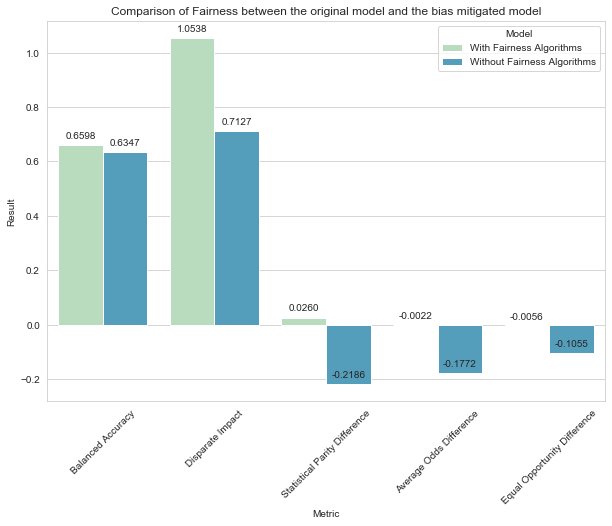

In [440]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Metric', y = 'Result', hue = 'Model', data = compp, palette = 'GnBu')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
# ax.axhline(0.0, color = '#000000', linewidth = 1, linestyle = '--')
# ax.axhline(1.0, color = '#000000', linewidth = 1, linestyle = '--')
plt.xticks(rotation = 45)
plt.title('Comparison of Fairness between the original model and the bias mitigated model')
plt.savefig('final_alg_comp.png', bbox_inches = 'tight')

**Predictive accuracy of original and transformed model**

In [441]:
transf_data_metric = ClassificationMetric(preprocessed_test, postprocesed_test_preds, unprivileged_groups, privileged_groups)

In [442]:
w, h = 2, 2
transf_priv_matrix = [[0 for x in range(w)] for y in range(h)]
transf_priv_matrix[0][0] = round(transf_data_metric.generalized_true_positive_rate(privileged = True), 2)
transf_priv_matrix[0][1] = round(transf_data_metric.generalized_false_positive_rate(privileged = True), 2)
transf_priv_matrix[1][0] = round(transf_data_metric.generalized_false_negative_rate(privileged = True), 2)
transf_priv_matrix[1][1] = round(transf_data_metric.generalized_true_negative_rate(privileged = True), 2)
transf_priv = pd.DataFrame(transf_priv_matrix, index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])

In [443]:
w, h = 2, 2
transf_unpriv_matrix = [[0 for x in range(w)] for y in range(h)]
transf_unpriv_matrix[0][0] = round(transf_data_metric.generalized_true_positive_rate(privileged = False), 2)
transf_unpriv_matrix[0][1] = round(transf_data_metric.generalized_false_positive_rate(privileged = False), 2)
transf_unpriv_matrix[1][0] = round(transf_data_metric.generalized_false_negative_rate(privileged = False), 2)
transf_unpriv_matrix[1][1] = round(transf_data_metric.generalized_true_negative_rate(privileged = False), 2)
transf_unpriv = pd.DataFrame(transf_unpriv_matrix, index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])

In [454]:
display(Markdown('#### Original Predictions: Privileged'))
print(priv_g)
display(Markdown('#### Original Predictions: Unprivileged'))
print(unpriv_g)
display(Markdown('#### Transformed Predictions: Privileged'))
print(transf_priv)
display(Markdown('#### Transformed Predictions: Unprivileged'))
print(transf_unpriv)

#### Original Predictions: Privileged

          Positive  Negative
Positive      0.66      0.53
Negative      0.34      0.47


#### Original Predictions: Unprivileged

          Positive  Negative
Positive      0.58      0.46
Negative      0.42      0.54


#### Transformed Predictions: Privileged

          Positive  Negative
Positive      0.68      0.55
Negative      0.32      0.45


#### Transformed Predictions: Unprivileged

          Positive  Negative
Positive      0.53      0.42
Negative      0.47      0.58


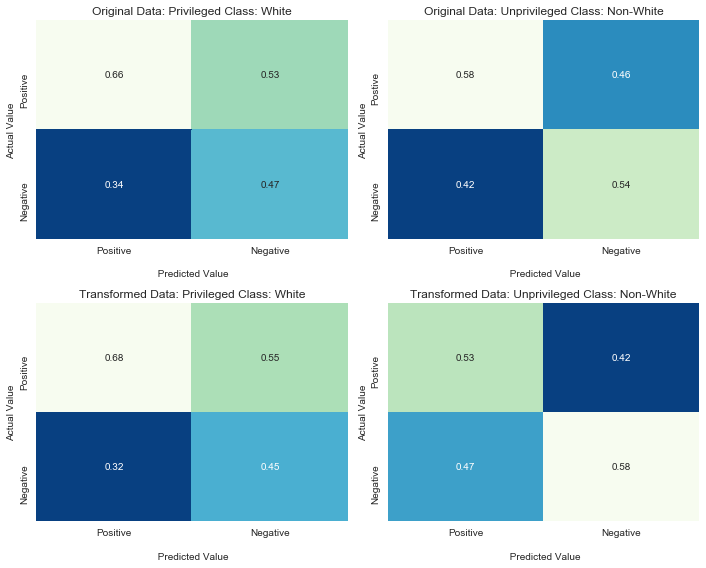

<Figure size 432x288 with 0 Axes>

In [455]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 8))

sns.heatmap(priv_g, annot = True, cmap = 'GnBu_r', ax = ax1, cbar = False)
ax1.set_title('Original Data: Privileged Class: White')
ax1.set_xlabel('\n Predicted Value')
ax1.set_ylabel('Actual Value')
ax1.xaxis.set_ticklabels(['Positive', 'Negative'])
ax1.yaxis.set_ticklabels(['Positive', 'Negative'])

sns.heatmap(unpriv_g, annot = True, cmap = 'GnBu_r', ax = ax2, cbar = False)
ax2.set_title('Original Data: Unprivileged Class: Non-White')
ax2.set_xlabel('\n Predicted Value')
ax2.set_ylabel('Actual Value')
ax2.xaxis.set_ticklabels(['Positive', 'Negative'])
ax2.yaxis.set_ticklabels(['Postive', 'Negative'])

sns.heatmap(transf_priv, annot = True, cmap = 'GnBu_r', ax = ax3, cbar = False)
ax3.set_title('Transformed Data: Privileged Class: White')
ax3.set_xlabel('\n Predicted Value')
ax3.set_ylabel('Actual Value')
ax3.xaxis.set_ticklabels(['Positive', 'Negative'])
ax3.yaxis.set_ticklabels(['Positive', 'Negative'])

sns.heatmap(transf_unpriv, annot = True, cmap = 'GnBu_r', ax = ax4, cbar = False)
ax4.set_title('Transformed Data: Unprivileged Class: Non-White')
ax4.set_xlabel('\n Predicted Value')
ax4.set_ylabel('Actual Value')
ax4.xaxis.set_ticklabels(['Positive', 'Negative'])
ax4.yaxis.set_ticklabels(['Postive', 'Negative'])

fig.tight_layout()
plt.show()
plt.savefig('transf_conf_matrices.png', bbox_inches = 'tight')